# **Deskriptive Statistik**
___
## Inhalt
1. [Übersicht](#übersicht)
   1. [Sensoren](#sensoren)
   2. [Fehlende Daten](#fehlende-daten)
2. [Anwesenheit](#anwesenheit)

3. [Raumklima](#raumklima)
4. [Thermischer Komfort](#thermischer-komfort)
5. [Heizung](#heizung)
6. [Fenster](#fensteröffnung)

## Importe

In [1]:
### Jupyter Einstellungen

%load_ext autoreload
%autoreload 2

### Python Pakete

import locale
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')
import datetime as dt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd
from pandas import IndexSlice as IDX
pd.set_option("display.max_rows", 5)

from sklearn.cluster import KMeans

import RomansThesis as RT
from RomansThesis import BUID, ROOMS, APPS, SENSORS, DB, AMB, getData, cleanBuiAppAxis, datemapaxis

DB

Lade WetterDB...
Lade Raumklima...
Lade gespeicherte Datenbank...                                                                


bui                          LB                                           \
app                           N                                            
room                          B                                            
value                     HK_IO  Rh Rh_amb T_amb T_amb_g24 Tair Thk Tset   
Datetime                                                                   
2021-02-08 11:00:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:01:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
...                         ...  ..    ...   ...       ...  ...  ..  ...   
2022-10-10 01:59:00+02:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2022-10-10 02:00:00+02:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   

bui                                      ...  MW                              \
app                                      ...   S                               
room                                  K  ...  WZ                               
value                     g_abs Fenster  ...  Rh Rh_amb T_amb T_amb_g24 Tair   
Datetime                                 ...                                   
2021-02-08 11:00:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:01:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
...                         ...     ...  ...  ..    ...   ...       ...  ...   
2022-10-10 01:59:00+02:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2022-10-10 02:00:00+02:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   

bui                                               
app                                               
room                                              
value                     Thk Top Tset Tsk g_abs  
Datetime                                          
2021-02-08 11:00:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:01:00+01:00 NaN NaN  NaN NaN   NaN  
...                        ..  ..  ...  ..   ...  
2022-10-10 01:59:00+02:00 NaN NaN  NaN NaN   NaN  
2022-10-10 02:00:00+02:00 NaN NaN  NaN NaN   NaN  

[876361 rows x 408 columns]

# **Übersicht**

## Sensoren

- Unterscheidung in Sensoren und ermittelte Datensätze

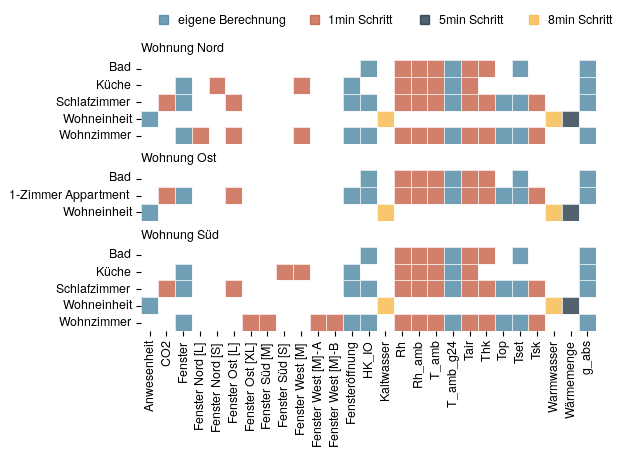

In [15]:
mapper = pd.DataFrame([RT.sensortypes, RT.sensorkind]).T.set_axis(['kind', 'type'], axis=1)
df = pd.concat([pd.Series({tuple(item.split('_')): sensor for item in location}) for sensor, location in RT.sensor_locations.items()])
df = df.rename_axis(['app', 'room']).rename('sensor').reset_index().assign(count = 1).pivot_table(columns=['app', 'room'], index='sensor', values='count', aggfunc=np.sum)
df = pd.concat({col: mapper.type.where(data.notna()) for col, data in df.iteritems()}, axis=1).T.infer_objects().dropna(how='all', axis=1)
norm = mpl.colors.BoundaryNorm([-0.5,0.5,1.5,6,9], ncolors=4)
cmap = mpl.colors.ListedColormap(['#407e9c','#c3553a',"#182d3e","#F6B53C"])
fig, axs = plt.subplots(3,1, sharex=True)
for i, (app, _data) in enumerate(df.groupby(level=0, axis=0)):
    sns.heatmap(data=_data.droplevel(0).rename(index=RT.NAMES), cmap=cmap, norm=norm, linewidths=.5, square=True, cbar=False, ax=axs[i], alpha=0.75)
    axs[i].set_title(f'Wohnung {APPS[app]}')
    axs[i].set_ylabel(None)
    axs[i].set_xlabel(None)
    if i < 2:
        axs[i].xaxis.set_visible(False)
plt.subplots_adjust(hspace=0.01, wspace=0.01)
fig.legend([mpl.patches.Patch(color=cmap(i), alpha=0.75) for i in range(4)], ['eigene Berechnung', '1min Schritt', '5min Schritt', '8min Schritt'], bbox_to_anchor=(.95,1.025),loc = 'upper right', handlelength=0.7, ncol=4)

## Fehlende Daten

In [16]:
sensors = DB.loc[:,DB.columns.get_level_values(3).isin(SENSORS[SENSORS == 'SENSOR_1min'].drop(['Tsk', 'global', 'windspeed']).index.to_list())]
pct_missing = RT.removeUnoccupied(sensors.isna()).sum().div(RT.removeUnoccupied(sensors.fillna(0)).notna().count())

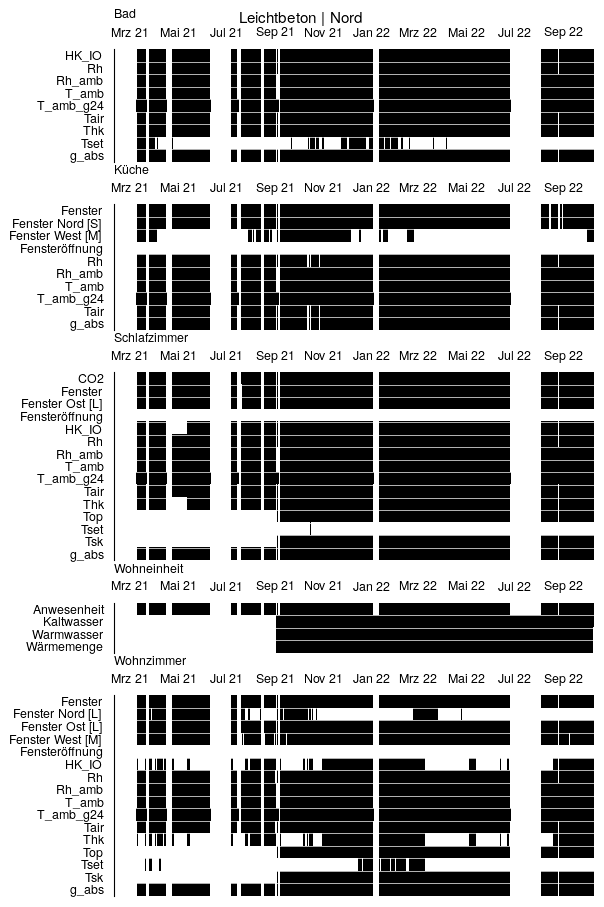

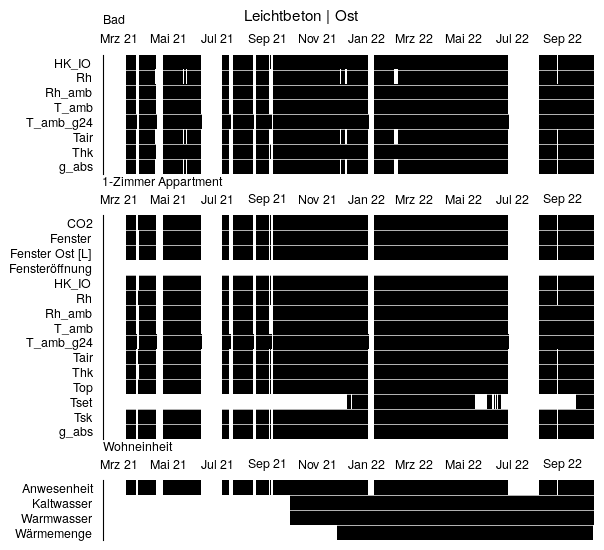

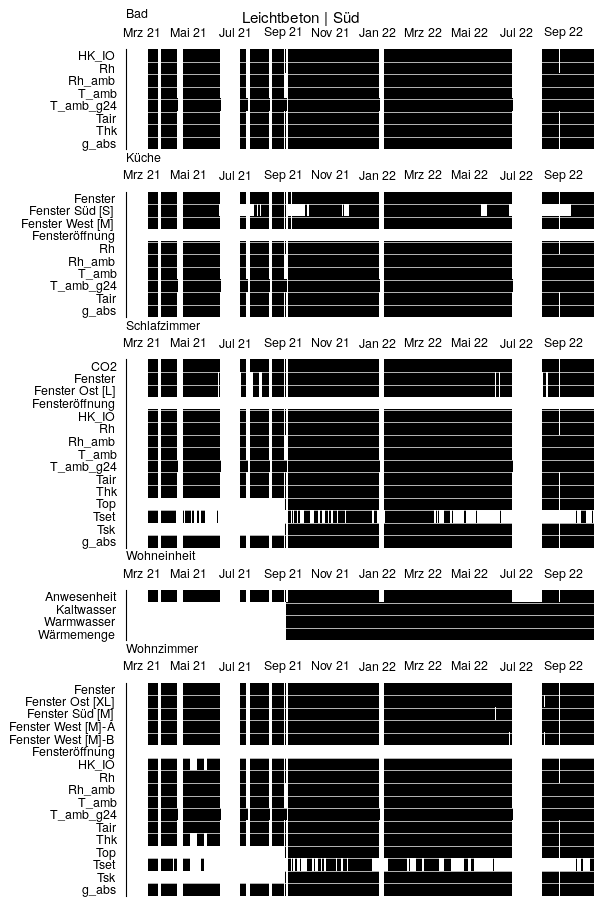

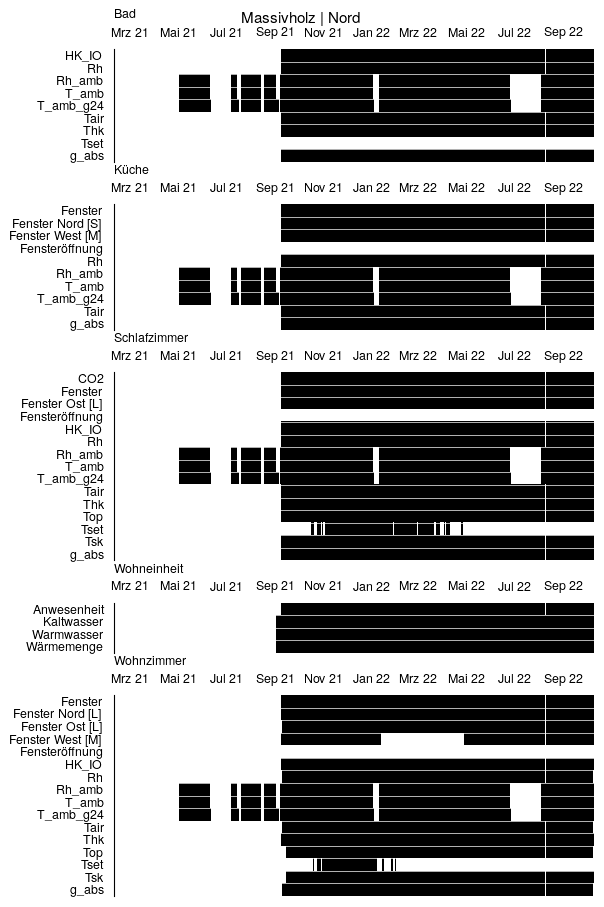

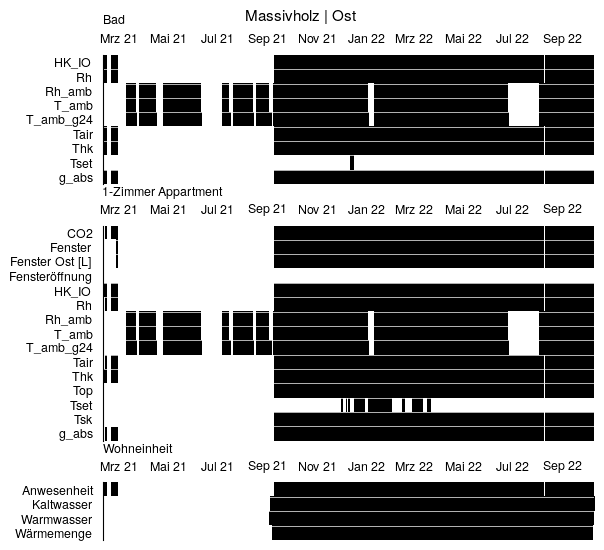

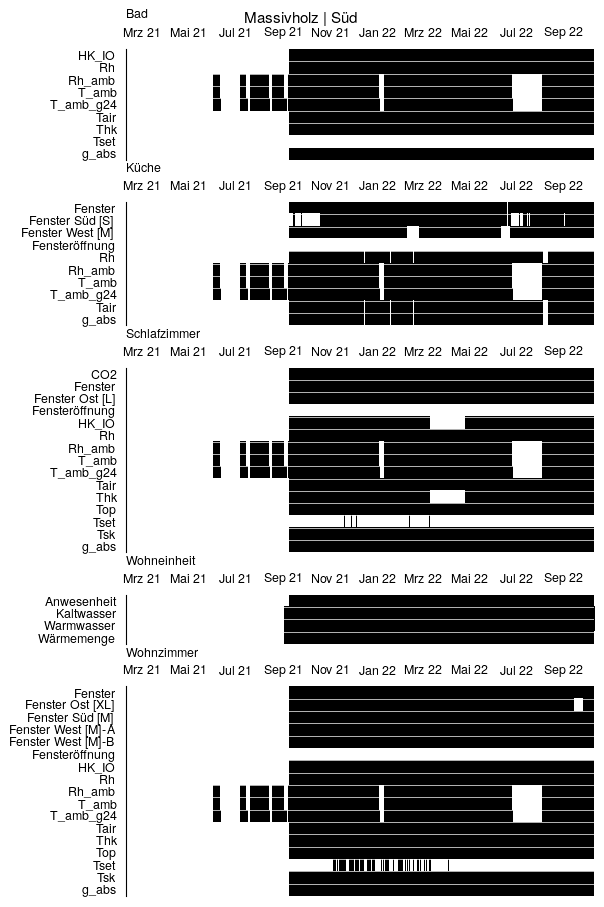

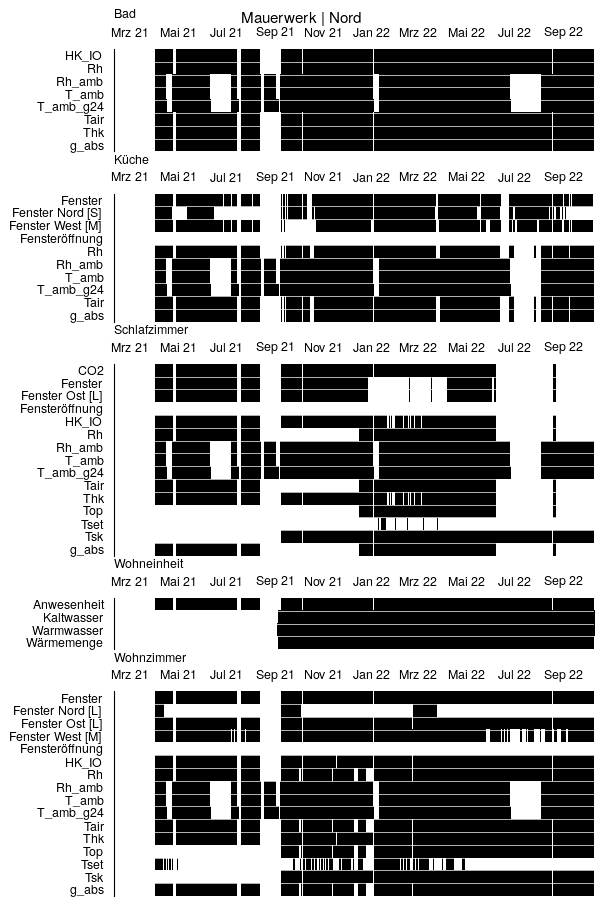

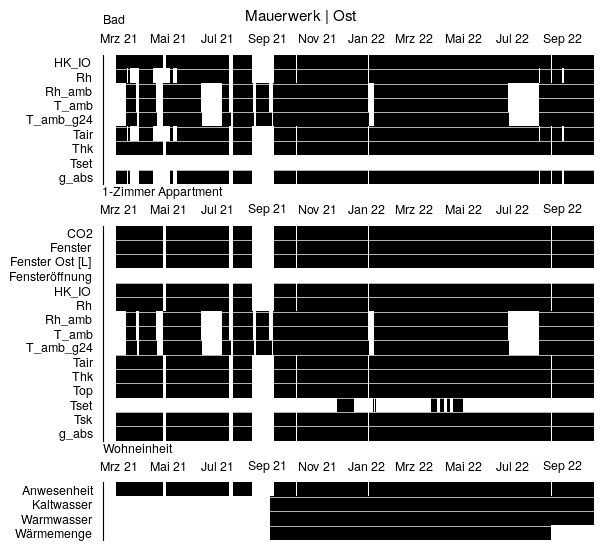

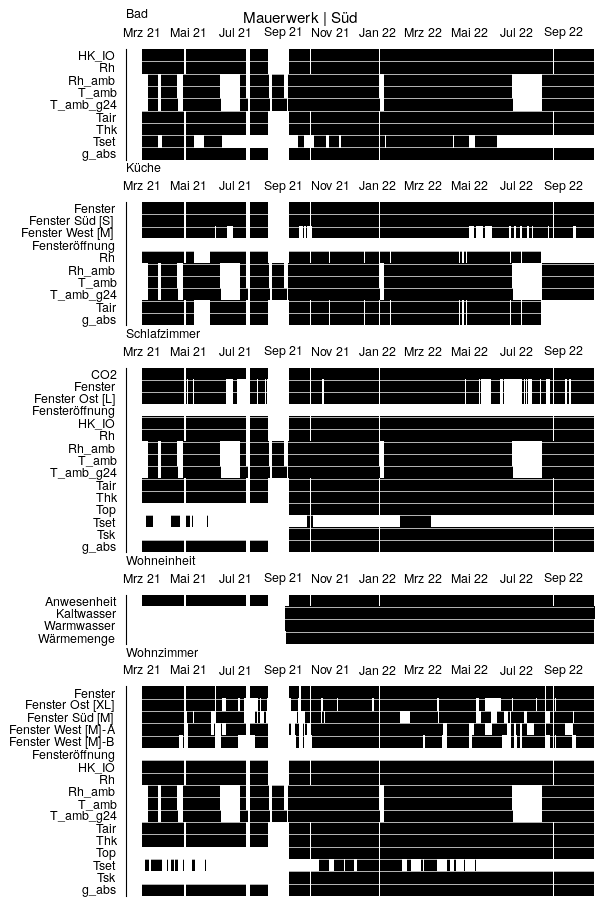

In [17]:
cmap = mpl.colors.ListedColormap(["w", "k"])
by = 'room'
for (bui, app), data in DB.groupby(level=[0,1], axis=1):
    rows = len(data[bui, app].columns.get_level_values(by).unique())
    fig, axs = plt.subplots(rows,1, **RT.size(subplots=[rows/2, 1]), gridspec_kw={'height_ratios':data[bui, app].groupby(level=by, axis=1).size().to_list()})
    fig.suptitle(f'{BUID[bui]} | {APPS[app]}')
    for r, (room, group) in enumerate(data[bui, app].groupby(level=by, axis=1)):
        RT.plotMissingData(group, ax= axs[r], level=1, title=f'{RT.NAMES[room]}', cmap=cmap)
    fig.tight_layout(pad=0.1)

## Übersichtstabelle

### Einzugsdaten

In [18]:
df = pd.read_csv('data/eb_Einzugsdaten.csv', sep=';', index_col=0, header=[0,1]).stack([0,1]).dropna().reset_index().drop(0,axis=1).set_axis(['Einzugsdatum', 'Haus', 'Wohnung'], axis=1).set_index(['Haus', 'Wohnung']).sort_index()
df.Einzugsdatum = df.Einzugsdatum.apply(lambda x: pd.to_datetime(x, dayfirst=True))
df = df.unstack(0).rename(columns=BUID, index=APPS).droplevel(0, axis=1)
(df.style
    .format(lambda x: x.strftime("%d. %b '%y"))
    # .to_latex('LaTex/tbls/tbl_pp_Einzugsdaten.tex',
    #         caption='Einzugsdaten der Mieter*Innen und Beginn der Messdaten', 
    #         siunitx=True, 
    #         hrules=True, 
    #         position= '!ht',
    #         position_float="centering",
    #         label='Einzugsdaten',
    #         )
)
df

Haus,Leichtbeton,Massivholz,Mauerwerk
Wohnung,,,
Nord,2020-07-01,2021-05-01,2021-04-01
Ost,2020-07-01,2020-10-01,2020-10-01
Süd,2020-07-01,2021-06-01,2021-03-01


In [19]:
df = DB.resample('D').mean().notna().groupby(['bui', 'app'], axis=1).median().replace(0, np.NaN).apply(lambda s: {'Beobachtungsbeginn': s.first_valid_index().strftime('%d.%m.%Y'), 'Beobachtungsende': s.last_valid_index().strftime('%d.%m.%Y'), 'Beobachtungsdauer': (s.last_valid_index()-s.first_valid_index()).days}, result_type='expand').T
df = df.join(
    #pct_missing.groupby(level=[0,1]).mean().mul(100).round(1).rename('Anteil fehlend')
    RT.removeUnoccupied(DB.resample('D').mean().notna().groupby(['bui', 'app'], axis=1).median()).eq(0).sum().rename('Tage ohne Daten')
)

(df
.rename(index=RT.NAMES).rename(index=RT.NAMES).rename_axis(['Haus', 'Wohnung'])
.style
.format(formatter={'Anteil fehlend': r"{:.1f} \si{{\percent}}"})
)

# **Anwesenheit**
__

[Zurück zum Anfang](#importe)

## Clustering

### Ermittle ein Signal für die Anwesenheit in einer Wohneinheit

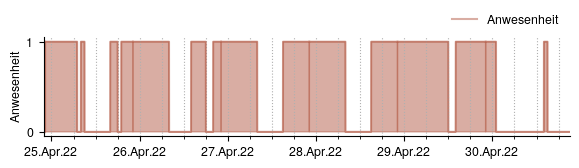

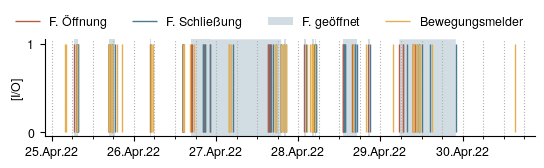

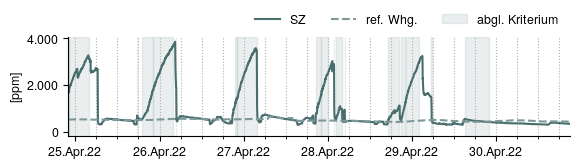

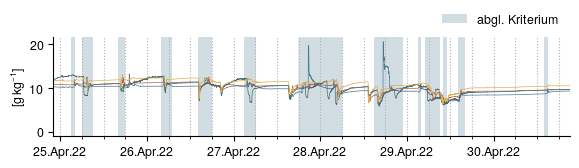

In [20]:
bui = 'LB'
app = 'S'
date = IDX['2022-04-25':'2022-04-30']

data = RT.getAnwesenheit(bui, app, date=date, plot=True, export=False)

In [21]:
df = getData(value='Anwesenheit', app=['N', 'S']).resample('H').max()
df.to_csv('data/exporte/Anwesenheitssignal.csv')
df


bui                                LB                      MH              \
app                                 N           S           N           S   
room                               WE          WE          WE          WE   
value                     Anwesenheit Anwesenheit Anwesenheit Anwesenheit   
Datetime                                                                    
2021-02-08 11:00:00+01:00         NaN         NaN         NaN         NaN   
2021-02-08 12:00:00+01:00         NaN         NaN         NaN         NaN   
...                               ...         ...         ...         ...   
2022-10-10 01:00:00+02:00         NaN         NaN         NaN         NaN   
2022-10-10 02:00:00+02:00         NaN         NaN         NaN         NaN   

bui                                MW              
app                                 N           S  
room                               WE          WE  
value                     Anwesenheit Anwesenheit  
Datetime                                           
2021-02-08 11:00:00+01:00         NaN         NaN  
2021-02-08 12:00:00+01:00         NaN         NaN  
...                               ...         ...  
2022-10-10 01:00:00+02:00         NaN         NaN  
2022-10-10 02:00:00+02:00         NaN         NaN  

[14607 rows x 6 columns]

### Suche zusammenhängende Zeiträume mit Abwesenheit (Urlaub)

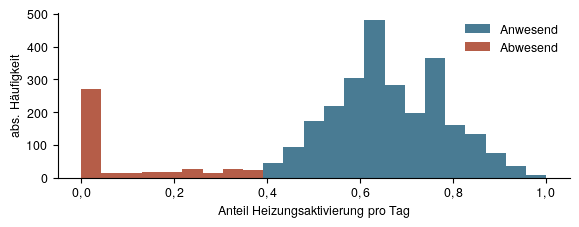

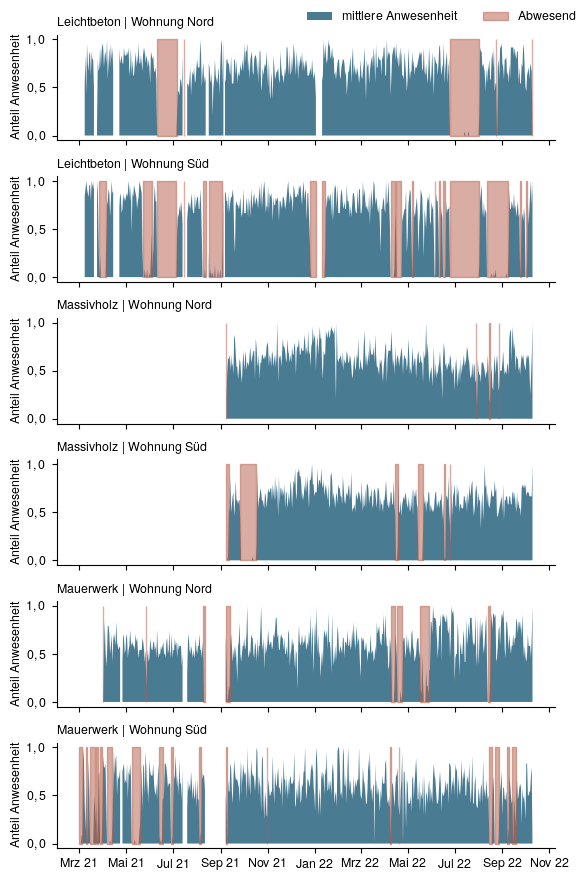

In [22]:
sig = RT.removeHolidays('filter', plot=True)

## Auswertung

### Auswertung auf Tagesebene

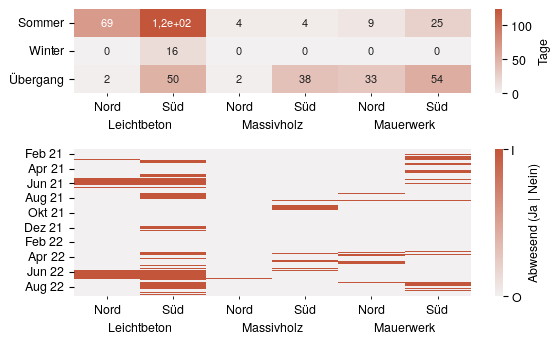

In [23]:
sig = RT.removeHolidays('filter').resample('D').mean().sort_index(axis=1)
fig, axs = plt.subplots(2,1, **RT.size(aspect=.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = sig.groupby(lambda s: RT.utils.getSeason(s.month)).sum().round()
ax = sns.heatmap(ax=axs[0], data=df, vmin=0, cmap=RT.Reds, annot=True, fmt='2.2n',annot_kws={"size":8}, cbar_kws={'label': 'Tage', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
ax = sns.heatmap(data=sig, cmap=RT.Reds, cbar_kws=dict(ticks=[0,1], label='Abwesend (Ja | Nein)'))
RT.utils.set_date_ticks(ax, sig.index.min().date(), sig.index.max().date(), freq='2M', date_format='%b %y')
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['O','I'])
cleanBuiAppAxis(ax, 'x')
ax.set(title=None, ylabel=None, xlabel=None)
fig.tight_layout()

### Auswertung auf stündlicher Ebene

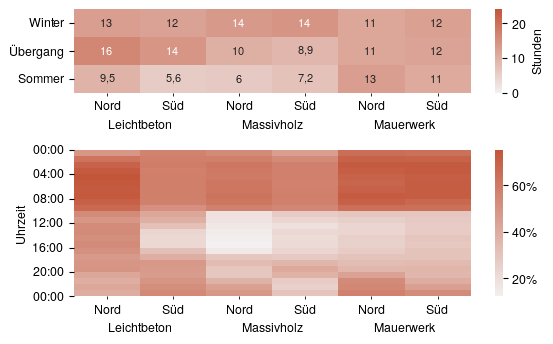

In [24]:
data = getData(app=['N', 'S'], value='Anwesenheit')
fig, axs = plt.subplots(2,1, **RT.size(aspect=.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = data.gt(0).groupby(level=[0,1], axis=1).max().resample('D').sum().div(60)
df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(ax=axs[0], data=df, vmin=0, vmax=1440/60, cmap=RT.Reds, annot=True, fmt='2.2n',annot_kws={"size":8}, cbar_kws={'label': 'Stunden', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = data.gt(0).groupby(level=[0,1], axis=1).max().groupby(lambda x: x.hour).mean()
ax = sns.heatmap(data=df, ax=axs[1], cmap=RT.Reds)
ax.set(title=None, ylabel=None, xlabel=None)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

# **Raumklima**
___
[Zurück zum Anfang](#importe)

## Identifikation und Bereinigung von Ausreißern
---

In [25]:
from RomansThesis import IND

### *Raumlufttemperatur*

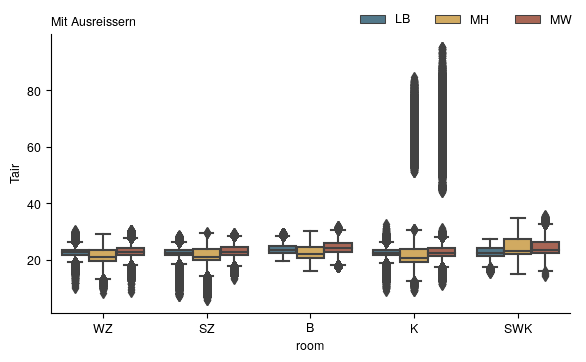

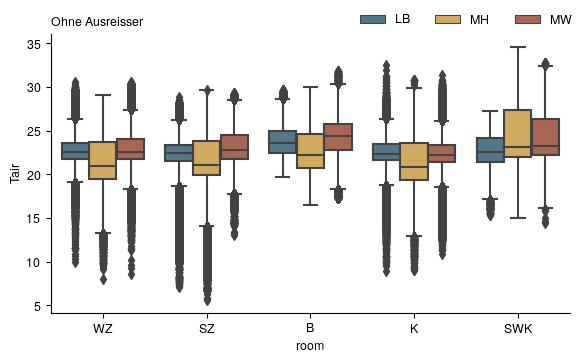

In [27]:
fig, ax = plt.subplots(1,1, sharex=True)
TAIR = IND[IND.columns[IND.columns.get_level_values(3).str.contains('trh_Tair')]].droplevel(3,axis=1).rename_axis(['bui', 'app', 'room'], axis=1).melt(value_name='Tair')
sns.boxplot(data=TAIR, x = 'room', y='Tair', hue='bui', order=ROOMS, hue_order=BUID, palette=RT.CLRS)
ax.set(title='Mit Ausreissern')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

fig, ax = plt.subplots(1,1, sharex=True)
sns.boxplot(data=DB.loc[:,IDX[:,:,:,'Tair']].stack([0,1,2]).reset_index(), x = 'room', y='Tair', hue='bui', order=ROOMS, hue_order=BUID, palette=RT.CLRS)
ax.set(title='Ohne Ausreisser')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()


### *relative Luftfeuchte*

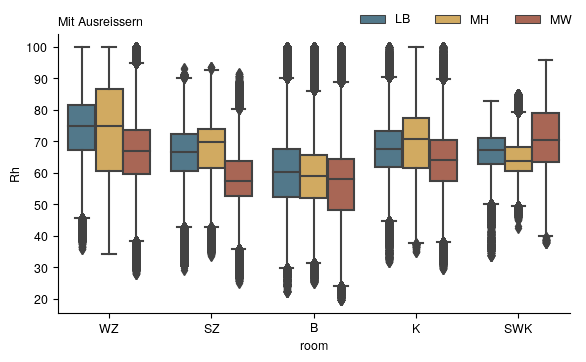

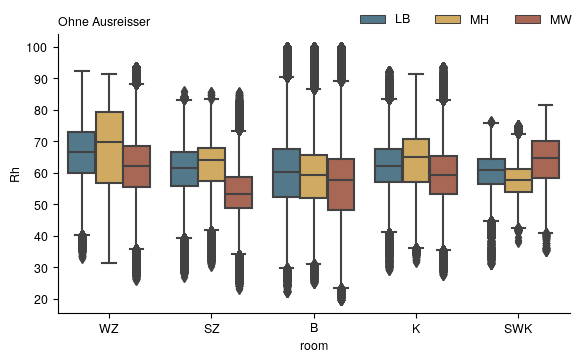

In [28]:
fig, ax = plt.subplots()

RH = IND[IND.columns[IND.columns.get_level_values(3).str.contains('trh_RH')]].droplevel(3,axis=1).rename_axis(['bui', 'app', 'room'], axis=1).melt(value_name='Rh')
sns.boxplot(data=RH, x = 'room', y='Rh', hue='bui', order=ROOMS, hue_order=BUID, palette=RT.CLRS)
ax.set(title='Mit Ausreissern')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

fig, ax = plt.subplots()

sns.boxplot(data=DB.loc[:,IDX[:,:,:,'Rh']].stack([0,1,2]).reset_index(), x = 'room', y='Rh', hue='bui', order=ROOMS, hue_order=BUID, palette=RT.CLRS)
ax.set(title='Ohne Ausreisser')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

### *Heizkörpertemperatur*

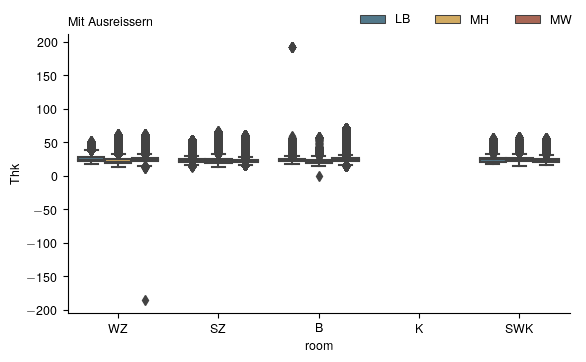

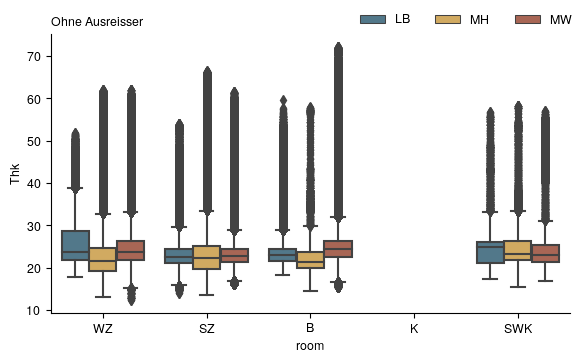

In [29]:
fig, ax = plt.subplots()
THK = IND[IND.columns[IND.columns.get_level_values(3).str.contains('pt_Thk')]].droplevel(3,axis=1).rename_axis(['bui', 'app', 'room'], axis=1).melt(value_name='Thk')
ax = sns.boxplot(data=THK, x = 'room', y='Thk', hue='bui', order=ROOMS, hue_order=BUID, palette=RT.CLRS)
ax.set(title='Mit Ausreissern')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

fig, ax = plt.subplots()
ax = sns.boxplot(data=DB.loc[:,IDX[:,:,:,'Thk']].stack([0,1,2]).reset_index(), x = 'room', y='Thk', hue='bui', order=ROOMS, hue_order=BUID, palette=RT.CLRS)
ax.set(title='Ohne Ausreisser')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

## Evaluiere die Korrekturfaktoren für die TRH-Sensoren

In [30]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

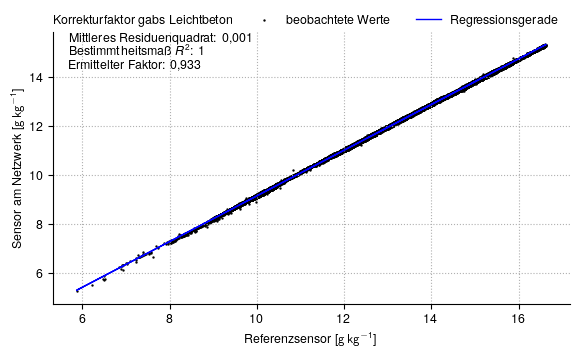

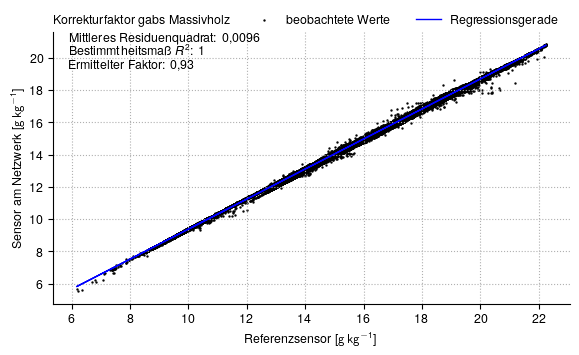

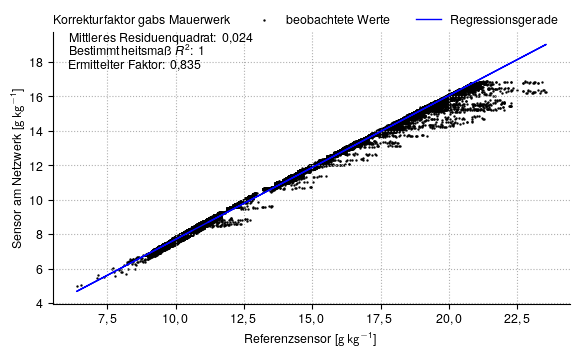

In [31]:
plot = True
if 'IND' not in globals():
    RT.getIND()

Tair = IND.loc[:,pd.IndexSlice[:,'O', 'SWK',:]].filter(like='Tair').filter(like='trh').rename_axis(['bui', 'app', 'room', 'value'], axis=1).stack([0,1,2]).reset_index().rename(columns={'m_trh1_Tair (°C)': 'trh_ref', 'm_trh_Tair (°C)':'trh', 'm_trh1_RH (%)': 'trh_ref', 'm_trh_RH (%)':'trh'})
rH = IND.loc[:,pd.IndexSlice[:,'O', 'SWK',:]].filter(like='RH').filter(like='trh').rename_axis(['bui', 'app', 'room', 'value'], axis=1).stack([0,1,2]).reset_index().rename(columns={'m_trh1_Tair (°C)': 'trh_ref', 'm_trh_Tair (°C)':'trh', 'm_trh1_RH (%)': 'trh_ref', 'm_trh_RH (%)':'trh'})
gabs = RT.comf.g_abs(Tair.set_index(['Datetime', 'bui', 'app', 'room']), rH.set_index(['Datetime', 'bui', 'app', 'room']))
coefs = {}
data = gabs
for bui, df in data.groupby('bui'):
    df.dropna(inplace=True)
    X = df['trh'].to_numpy().reshape(-1, 1)
    y = df['trh_ref'].to_numpy().reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    regr = linear_model.RidgeCV().fit(X_train, y_train)
    coefs[('gabs', bui)] = regr.coef_[0][0]

    if plot:
        y_pred = regr.predict(X_test)
        fig, ax = plt.subplots()
        ax.set_title(f'Korrekturfaktor gabs {BUID[bui]}')
        ax.scatter(X_test, y_test, color="black", s=.5, label='beobachtete Werte')
        ax.plot(X_test, y_pred, color="blue", linewidth=1, label='Regressionsgerade')
        text = '\n'.join([
            f"Mittleres Residuenquadrat: {mean_squared_error(y_test, y_pred):.2n}",
            f"Bestimmtheitsmaß $R^2$: {r2_score(y_test, y_pred):.2n}",
            f"Ermittelter Faktor: {regr.coef_[0][0]:.3n}"])
        ax.grid()
        ax.set(ylabel='Sensor am Netzwerk $[\\si{\\gram\\per\\kilo\\gram}]$', xlabel='Referenzsensor $[\\si{\\gram\\per\\kilo\\gram}]$')
        ax.text(0.03,1, text, transform=ax.transAxes, ha='left', va='top')
        ax.legend(ncol=2, frameon=False, bbox_to_anchor = (1, .98), loc='lower right')
        fig.tight_layout()

,Rh,Tair
LB,-5.35,-0.01
MH,-4.07,0.08
MW,-13.58,-0.39


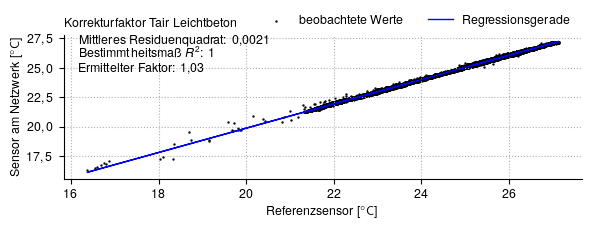

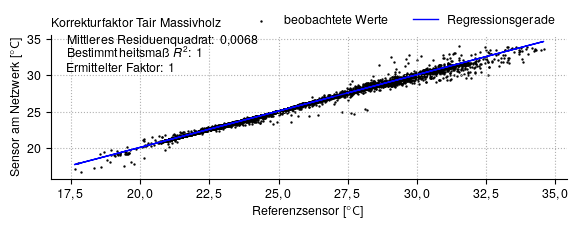

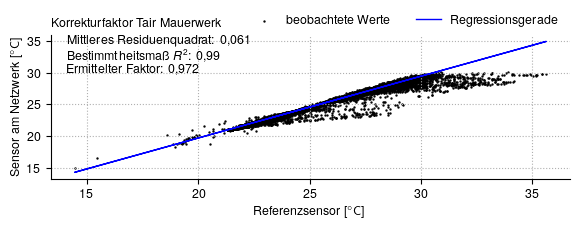

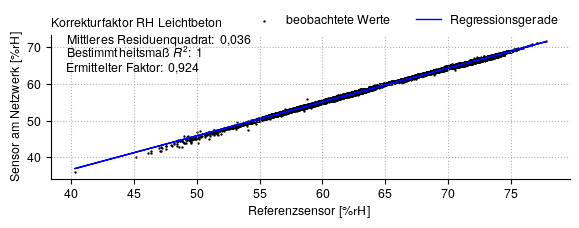

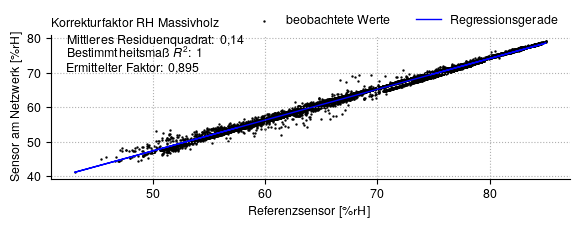

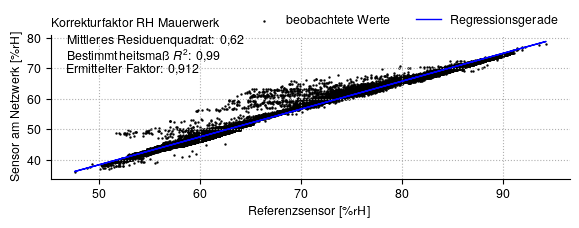

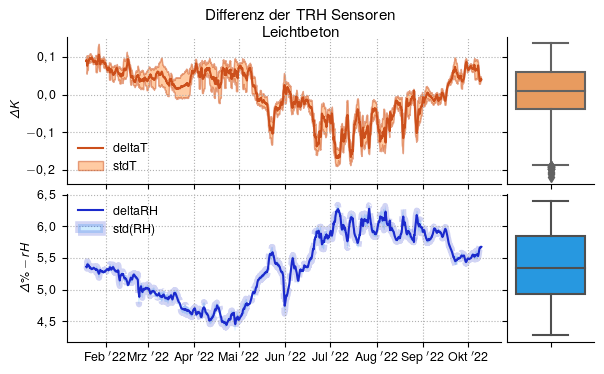

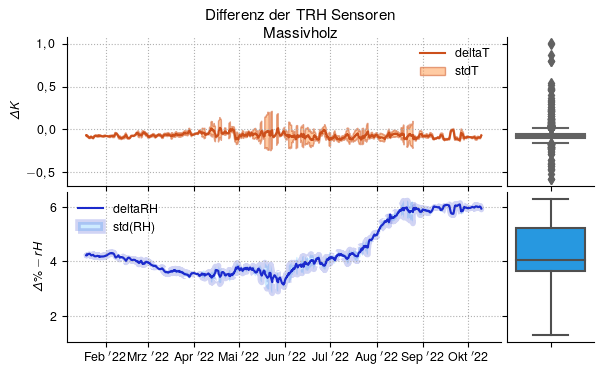

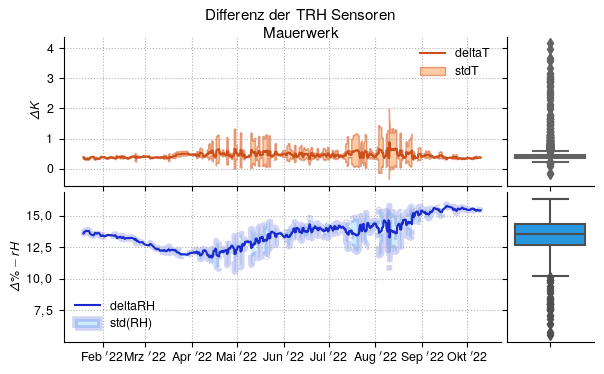

In [32]:
RT.updateKorrektur_lin(toTex=False)
RT.updateKorrektur_fix(toTex=False)

## Auswertung der Lufttemperatur

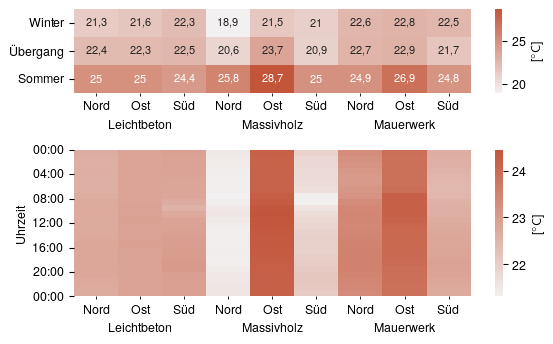

In [33]:
data = DB.loc[:,IDX[:,['N','O', 'S'],:,'Tair']].groupby(level=[0,1], axis=1).median()

df = data.resample('D').mean()
fig, axs = plt.subplots(2,1, **RT.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
ax = sns.heatmap(ax=axs[0], data=df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']), cmap=RT.Reds, annot=True, fmt='.3n',annot_kws={"size":8},cbar_kws={'label': r'$[\si{\celsius}]$', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')

df = data
ax = sns.heatmap(ax=axs[1], data=df.groupby(df.index.hour).mean(), cmap=RT.Reds, cbar_kws={'label': r'$[\si{\celsius}]$'} )
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

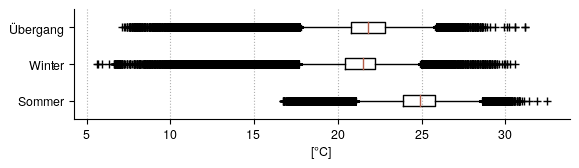

In [34]:
df = getData(value='Tair', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: RT.utils.getSeason(x.index))
x = {season: group['Tair'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**RT.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), sym='+', vert=False)
ax.set(xlabel=r'[\si{\celsius}]')
ax.grid(axis='x')
fig.tight_layout()

## operative Raumtemperatur

### *Näherungsweise Bestimmung der über Lufttemperatur*

Ermittleter Faktor: 
 [[0.97734539]]
Mittleres Residuenquadrat: 0.08
$R^2$: 0.97
Ermittleter Faktor: 
 [[1.00488357]]
Mittleres Residuenquadrat: 0.10
$R^2$: 0.99
Ermittleter Faktor: 
 [[0.97545236]]
Mittleres Residuenquadrat: 0.23
$R^2$: 0.93


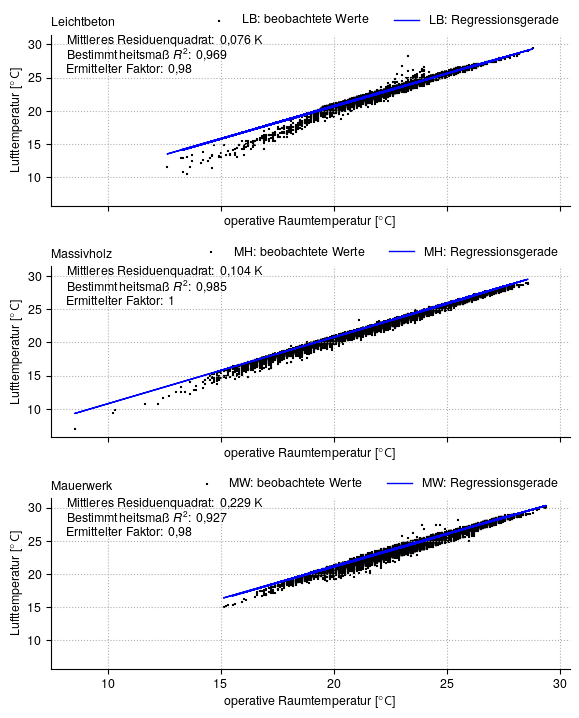

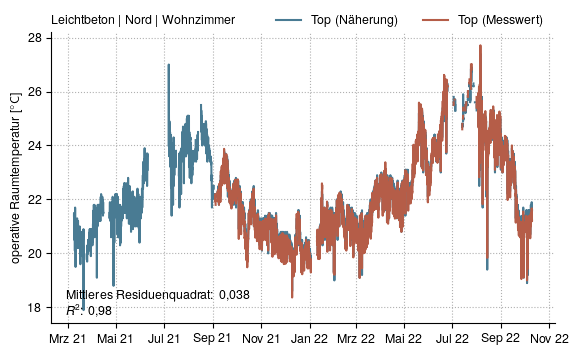

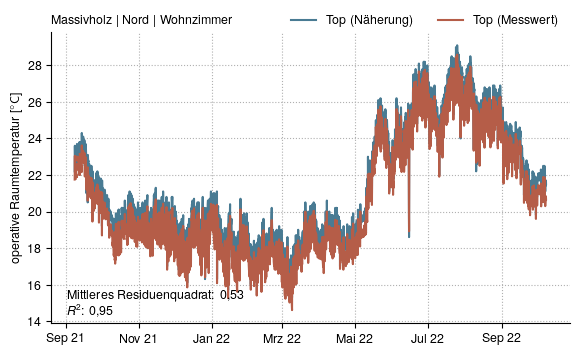

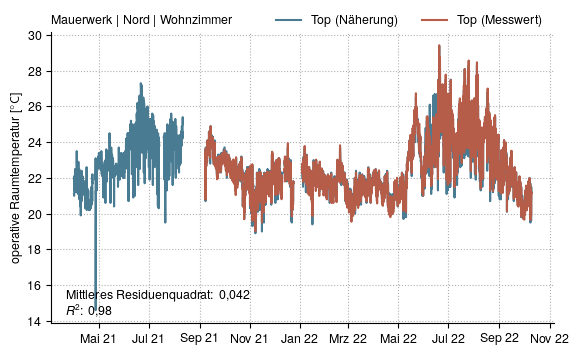

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

df = RT.estimateOperativeTemperature(mode='linear', plot=True, export=False)
bui, app, room = 'LB', 'N', 'WZ'
for bui in BUID:
    est = df[(bui, app, room)]
    obs = RT.getData(bui = bui, app = app, room = room, value = 'Top').resample('H').mean()
    fig, ax = plt.subplots()
    ax.plot(est, label=r'Top (Näherung)')
    ax.plot(obs, label=r'Top (Messwert)')
    ax.set_title(f'{BUID[bui]} | {APPS[app]} | {ROOMS[room]}')
    ax.legend(ncol=2, frameon=False, bbox_to_anchor = (1, .98), loc='lower right')
    ax.set_ylabel(r'operative Raumtemperatur $[\si{\celsius}]$')
    ax.grid()
    text = '\n'.join([
        f"Mittleres Residuenquadrat: {mean_squared_error(*est.join(obs, lsuffix='pred', rsuffix='obs').dropna().to_numpy().T):.2n}", 
        f"$R^2$: {r2_score(*est.join(obs, lsuffix='pred', rsuffix='obs').dropna().to_numpy().T):.2n}"])

    ax.text(0.03,0.03, text, transform=ax.transAxes, ha='left')
    fig.tight_layout()

In [37]:
TOP = RT.estimateOperativeTemperature(mode='pred').loc[:,IDX[:,['N', 'O', 'S'],:,:]]
TOP.head()

bui                        LB                                      ...  MW  \
app                         N               O       S              ...   N   
room                        B   K  SZ  WZ   B SWK   B   K  SZ  WZ  ...   B   
value                     Top Top Top Top Top Top Top Top Top Top  ... Top   
Datetime                                                           ...       
2021-02-08 11:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2021-02-08 12:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2021-02-08 13:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2021-02-08 14:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   
2021-02-08 15:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  ... NaN   

bui                                                            
app                                     O       S              
room                        K  SZ  WZ   B SWK   B   K  SZ  WZ  
value                     Top Top Top Top Top Top Top Top Top  
Datetime                                                       
2021-02-08 11:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-02-08 12:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-02-08 13:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-02-08 14:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2021-02-08 15:00:00+01:00 NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 30 columns]

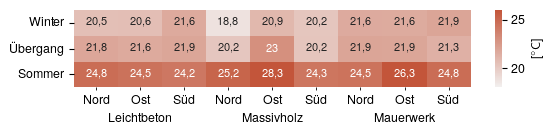

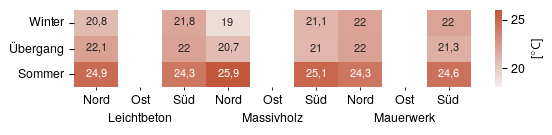

In [38]:
data = DB.loc[:,IDX[:,['N','O', 'S'],:,'Top']].groupby(level=[0,1], axis=1).median()

kws = dict(cmap=RT.Reds, annot=True, fmt='.3n',annot_kws={"size":8}, vmin=18, vmax=26, cbar_kws=dict(label=r'[$\si{\celsius}$]', aspect=12))

top_messung = data.resample('D').mean()
top_messung = top_messung.groupby(RT.utils.getSeason(top_messung.index)).mean().where(top_messung.groupby(RT.utils.getSeason(top_messung.index)).count() > 7).reindex(['Winter', 'Übergang', 'Sommer'])

fig, axs = plt.subplots(**RT.size(aspect=0.25))
ax = sns.heatmap(data=top_messung, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

df = TOP.loc[data.loc[:,IDX[:,['N','S']]].resample('H').mean().dropna(how='all').index,:].groupby(level=[0,1], axis=1).median().resample('D').mean()
df = df.groupby(RT.utils.getSeason(df.index)).mean().where(df.groupby(RT.utils.getSeason(df.index)).count() > 7).reindex(['Winter', 'Übergang', 'Sommer'])
df.loc[:,IDX[:,'O']] = np.NaN
fig, ax = plt.subplots(1,1, **RT.size(aspect=.25))
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

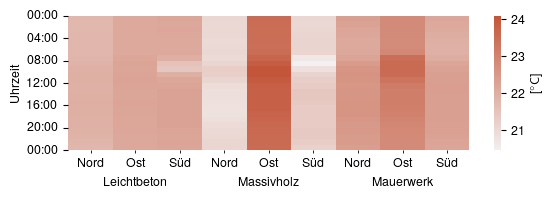

In [39]:
df = data
fig, ax = plt.subplots(**RT.size(aspect=0.35))
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=RT.Reds, ax = ax, cbar_kws={'label': r'[$\si{\celsius}$]'} )
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

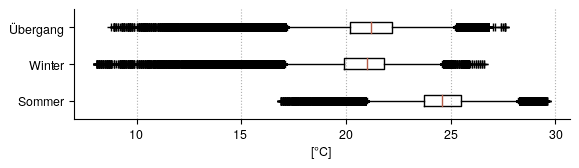

In [40]:
df = getData(value='Top', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: RT.utils.getSeason(x.index))
x = {season: group['Top'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**RT.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), sym='+', vert=False)
ax.set(xlabel=r'[\si{\celsius}]')
ax.grid(axis='x')
fig.tight_layout()

## Luftfeuchte

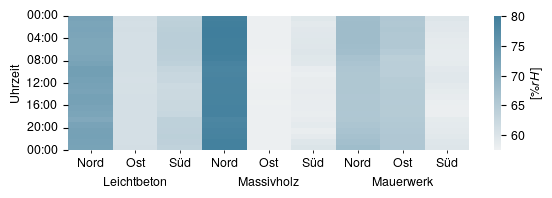

In [41]:
data = getData(value='Rh').groupby(level=[0,1], axis=1).max()
fig = plt.figure(**RT.size(aspect=0.35))
ax = sns.heatmap(data=data.groupby(data.index.hour).median(), cmap=RT.Blues, cbar_kws={'label': r'[$\si{\percent} rH$]', 'format': '%.0f%%'} )
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

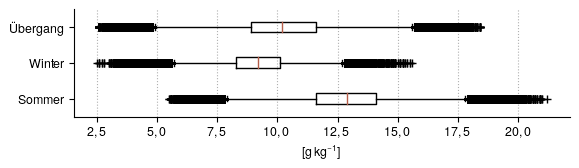

In [42]:
df = getData(value='g_abs', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: RT.utils.getSeason(x.index))
x = {season: group['g_abs'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**RT.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), sym='+', vert=False)
ax.set(xlabel=r'[\si{\gram\per\kilogram}]')
ax.grid(axis='x')
fig.tight_layout()

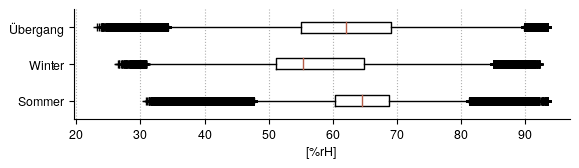

In [43]:
df = getData(value='Rh', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: RT.utils.getSeason(x.index))
x = {season: group['Rh'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**RT.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), sym='+', vert=False)
ax.set(xlabel=r'[\si{\percent rH}]')
ax.grid(axis='x')
fig.tight_layout()

In [44]:
rh_raw = pd.concat({(bui, app): RT.getCleanTRHdata(bui, app, sensortype='Rh', correction=False).max(axis=1) for bui in BUID for app in APPS}, axis=1)
g_raw = pd.concat({(bui, app): RT.comf.g_abs(RT.getCleanTRHdata(bui, app, sensortype='Tair', correction=False).droplevel(1, axis=1), RT.getCleanTRHdata(bui, app, sensortype='Rh', correction=False).droplevel(1,axis=1)).max(axis=1) for bui in BUID for app in APPS}, axis=1)

rh_lin = pd.concat({(bui, app): RT.getCleanTRHdata(bui, app, sensortype='Rh', correction='lin').max(axis=1) for bui in BUID for app in APPS}, axis=1)
g_lin = pd.concat({(bui, app): RT.comf.g_abs(RT.getCleanTRHdata(bui, app, sensortype='Tair', correction=False).droplevel(1, axis=1), RT.getCleanTRHdata(bui, app, sensortype='Rh', correction='lin').droplevel(1,axis=1)).max(axis=1) for bui in BUID for app in APPS}, axis=1)

rh_fix = pd.concat({(bui, app): RT.getCleanTRHdata(bui, app, sensortype='Rh', correction='fix').max(axis=1) for bui in BUID for app in APPS}, axis=1)
g_fix = pd.concat({(bui, app): RT.comf.g_abs(RT.getCleanTRHdata(bui, app, sensortype='Tair', correction=False).droplevel(1, axis=1), RT.getCleanTRHdata(bui, app, sensortype='Rh', correction='fix').droplevel(1,axis=1)).max(axis=1) for bui in BUID for app in APPS}, axis=1)

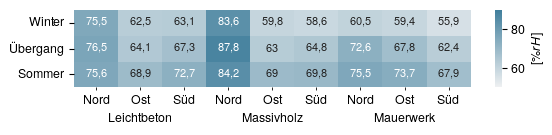

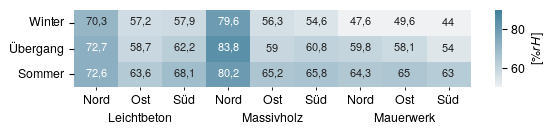

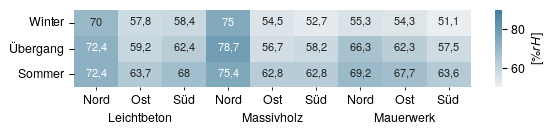

In [45]:
kws = dict(cmap=RT.Blues, annot=True, fmt='.3n',annot_kws={"size":8}, vmin=50, vmax=90, cbar_kws=dict(label=r'$[\si{\percent} rH]$', aspect=12))

# rH ohne Korrektur
fig, ax = plt.subplots(**RT.size(aspect=0.25))
df = rh_raw.resample('D').mean()    # Tagesmiitel
df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']) 
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

# rH mit statischer Korrektur
fig, ax = plt.subplots(**RT.size(aspect=0.25))
df = rh_fix.resample('D').mean()
df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

#rH mit linearer Korrektur
fig, ax = plt.subplots(**RT.size(aspect=0.25))
df = rh_lin.resample('D').mean()
df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

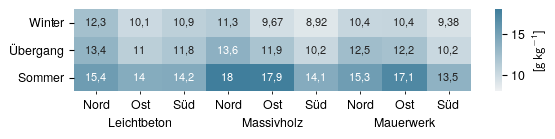

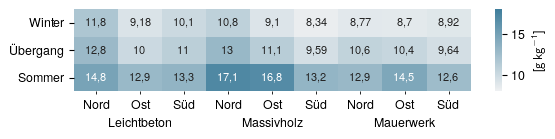

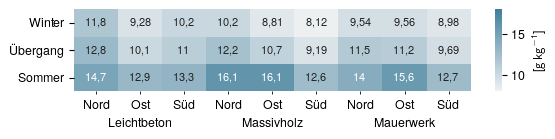

In [46]:
kws = dict(cmap=RT.Blues, annot=True, fmt='.3n',annot_kws={"size":8}, vmin=8, vmax=18, cbar_kws=dict(label=r'$[\si{\gram\per\kilogram}]$', aspect=12))

# g ohne Korrektur
fig, ax = plt.subplots(**RT.size(aspect=0.25))
df = g_raw.resample('D').mean()
df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

# g mit statischer Korrektur
fig, ax = plt.subplots(**RT.size(aspect=0.25))
df = g_fix.resample('D').mean()
df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax)
fig.tight_layout()

# g mit linearer Korrektur
fig, ax = plt.subplots(**RT.size(aspect=0.25))
df = g_lin.resample('D').mean()
df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(data=df,ax=ax, **kws)
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax)
fig.tight_layout()

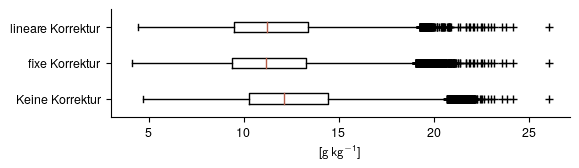

In [47]:
fig, ax = plt.subplots(**RT.size(.3))
ax.boxplot([g_raw.resample('H').mean().stack([0,1]), g_fix.resample('H').mean().stack([0,1]), g_lin.resample('H').mean().stack([0,1])], labels=['Keine Korrektur', 'fixe Korrektur', 'lineare Korrektur'], sym='+', vert=False)
ax.set(xlabel=r'[$\si{\gram\per\kilogram}$]')
fig.tight_layout()

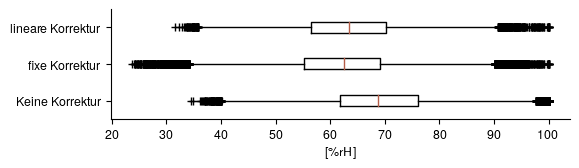

In [48]:
fig, ax = plt.subplots(**RT.size(.3))
ax.boxplot([rh_raw.resample('H').mean().stack([0,1]), rh_fix.resample('H').mean().stack([0,1]), rh_lin.resample('H').mean().stack([0,1])], labels=['Keine Korrektur', 'fixe Korrektur', 'lineare Korrektur'], sym='+', vert=False)
ax.set(xlabel=r'[$\si{\percent rH}$]')
fig.tight_layout()

Timestep is <Minute>. Resampling to Hour...
Timestep is <Minute>. Resampling to Hour...


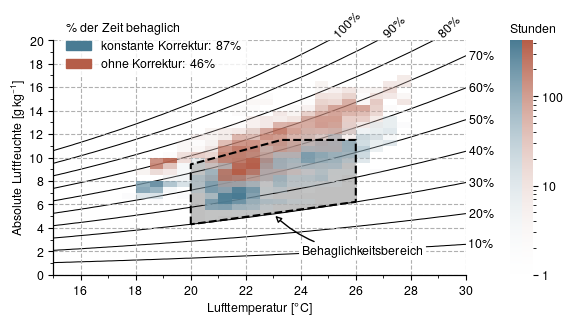

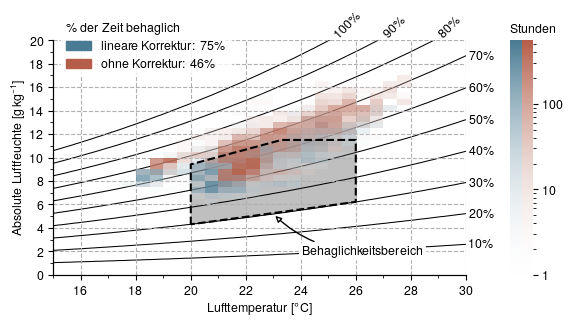

In [49]:
app = 'N'
room = 'SZ'
mapper = {'fix': 'konstante', 'lin': 'lineare'}
bui = 'MW'
for correction in ['fix', 'lin']:
    _temp = pd.concat([RT.getCleanTRHdata(bui, app, sensortype='Tair', correction=correction)[room].squeeze().rename(f'{mapper[correction]} Korrektur'), RT.getCleanTRHdata(bui, app, sensortype='Tair', correction=False)[room].squeeze().rename('ohne Korrektur')], axis=1)
    _rh = pd.concat([RT.getCleanTRHdata(bui, app, sensortype='Rh', correction=correction)[room].squeeze().rename(f'{mapper[correction]} Korrektur'), RT.getCleanTRHdata(bui, app, sensortype='Rh', correction=False)[room].squeeze().rename('ohne Korrektur')], axis=1)
    hx = RT.comf.hxdiagramm(_temp, _rh, kind='hist', cmap=[RT.red,RT.blue], **RT.size(aspect=.5))
    hx.set_title(f'{BUID[bui]} | {APPS[app]} | {ROOMS[room]}', fig=False, title=False)

## CO $_2$ Konzentration

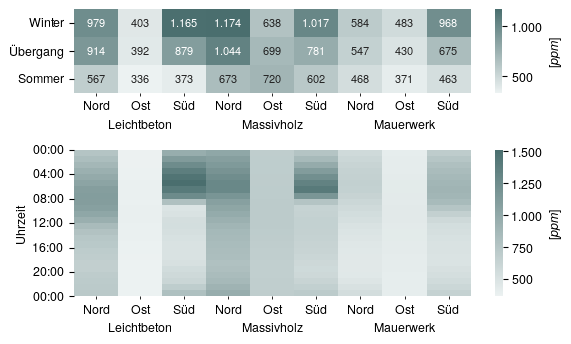

In [50]:
data = DB.loc[:,IDX[:,['N', 'O', 'S'],:,'CO2']].groupby(level=[0,1], axis=1).max()

fig, axs = plt.subplots(2,1, **RT.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = data.resample('D').mean()
df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']).round(0)
ax = sns.heatmap(ax=axs[0], data=df, cmap=RT.Greens, annot=True, fmt='.4n',annot_kws={"size":8},cbar_kws={'label': r'$[ppm]$', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = DB.loc[:,IDX[:,['N', 'O', 'S'],:,'CO2']].groupby(level=[0,1], axis=1).max()
ax = sns.heatmap(ax=axs[1], data=df.groupby(df.index.hour).mean(), cmap=RT.Greens, fmt='.4n',annot_kws={"size":8},cbar_kws={'label': r'$[ppm]$'})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

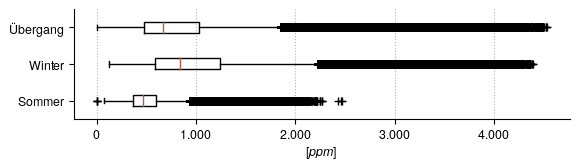

In [51]:
df = getData(value='CO2', app=['N', 'S'], room=['WZ', 'SZ', 'K']).stack(['bui', 'app', 'room']).assign(Season=lambda x: RT.utils.getSeason(x.index))
x = {season: group['CO2'].dropna().reset_index(drop=True) for season, group in df.groupby('Season')}
fig, ax = plt.subplots(**RT.size(.3))
ax.boxplot(x = x.values(), labels=x.keys(), vert=False, sym='+')
ax.set(xlabel=r'$[ppm]$')
ax.grid(axis='x')
fig.tight_layout()

# Wetter
___
[Zurück zum Anfang](#importe)

In [52]:
from geopy import geocoders
from meteostat import Stations, Hourly
from timezonefinder import TimezoneFinder

location = 'Mietraching'

loc = geocoders.Nominatim(user_agent="RamonsRobusteThesis").geocode(location)
station = Stations().nearby(loc.latitude, loc.longitude).fetch(1)
timezone = TimezoneFinder().timezone_at(lng=loc.longitude, lat=loc.latitude)
start = AMB.resample('D').mean().index.min().tz_convert('utc').to_pydatetime().replace(tzinfo=None)
ende = AMB.resample('D').mean().index.max().tz_convert('utc').to_pydatetime().replace(tzinfo=None)
refdata = Hourly(station, start, ende).fetch().tz_localize('utc').tz_convert(timezone)
refdata

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2021-03-08 00:00:00+01:00,3.1,1.8,91.0,0.1,NaN,251.0,7.6,NaN,1020.6,0.0,NaN
2021-03-08 01:00:00+01:00,2.7,2.0,95.0,0.0,NaN,265.0,9.0,NaN,1020.8,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-09 23:00:00+02:00,7.4,7.3,99.0,0.0,NaN,97.0,7.9,NaN,1019.9,0.0,3.0
2022-10-10 00:00:00+02:00,7.0,6.7,98.0,0.0,NaN,94.0,6.1,NaN,1019.8,0.0,3.0


## Außenlufttemperatur

In [53]:
df = AMB.T_amb.groupby(RT.utils.getSeason(AMB.index)).agg(['mean', 'median', 'std']).reindex(['Übergang']).rename_axis('Jahreszeit')
df = pd.concat( (df, AMB.T_amb.groupby(RT.utils.getSeason(AMB.index, übergang=False)).agg(['mean', 'median', 'std']).reindex([ 'Frühling', 'Herbst']).rename_axis('Jahreszeit')))
(df.style
.format(formatter='{:.1f} °C', escape='latex')
.format(formatter='{:.1f} K', escape='latex', subset=['std'])
# .to_latex(
#     './LaTex/tbls/tbl_pp_vgl_seasons.tex',
#     caption='Vergleich der des Mittelwerts, des Medians und der Standardabweichung der Außenlufttemperatur für die Klassifikation nach Frühlung und Herbst sowie der Zusamenfassung als Übergang.',
#     clines="skip-last;data",
#     siunitx=True,
#     hrules=True,
#     position= '!ht',
#     position_float="centering",
#     multicol_align="|c|",
#     label='tbl:SeasonsTambVgl')
)
df

,mean,median,std
Jahreszeit,,,
Übergang,9.588099,9.2,7.243682
Frühling,9.141198,8.9,7.389955
Herbst,10.178589,9.7,7.002171


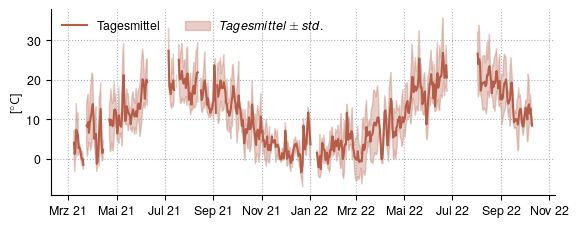

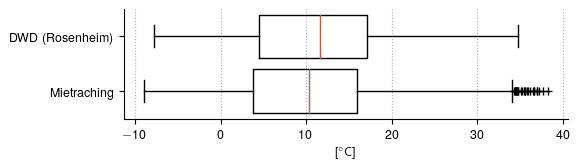

In [54]:
mean, std = AMB['T_amb'].resample('D').mean(), AMB['T_amb'].resample('D').std()
lower, upper = mean - std, mean + std
x = mean.index

fig, ax = plt.subplots(**RT.size(aspect=0.4))
ax.plot(mean, c=RT.CMAP[1], label=r'Tagesmittel')
ax.fill_between(x, lower, upper, alpha=0.3, color=RT.CMAP[1], label=r'$Tagesmittel \pm std.$')
ax.set_ylabel(r'$[\si{\celsius}]$')
#ax.set_title('Außenlufttemperatur $T_{amb}$')
ax.grid(axis='both', ls = 'dotted')
ax.legend(loc='upper left', ncol=2)
fig.tight_layout()

fig, ax = plt.subplots(**RT.size(aspect=0.3))
ax.boxplot([AMB['T_amb'].resample('H').mean().dropna(), refdata['temp'].dropna()], sym='+', medianprops={'color':RT.CMAP[1]}, widths=[0.8, 0.8], vert=False)
#ax.set_title('Vergleich mit der nächsen DWD-Station')
ax.set_xlabel(r'$[\si{\celsius}]$')
ax.set_yticks([1, 2], ['Mietraching', 'DWD (Rosenheim)'], rotation = 0)
ax.grid(axis='x', ls = 'dotted')
fig.tight_layout()

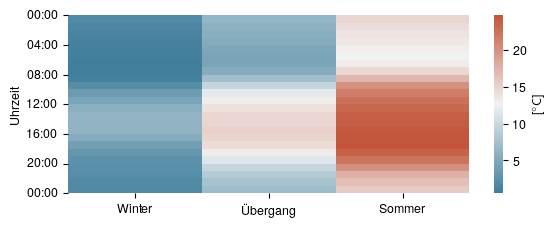

In [55]:
fig, ax = plt.subplots(**RT.size(aspect=0.4))
ax = sns.heatmap(pd.concat([group.groupby(group.index.hour).mean().rename(season) for season, group in AMB.T_amb.groupby(RT.utils.getSeason(AMB.index))], axis=1)[['Winter', 'Übergang', 'Sommer']], cmap=RT.HEATMAP, cbar_kws={'label': r'[$\si{\celsius}$]'})
ax.set(ylabel=None, xlabel=None)
datemapaxis(ax)
fig.tight_layout()

In [56]:
df = AMB.T_amb.groupby(RT.utils.getSeason(AMB.index)).agg(['min', 'max', 'mean', 'median', 'std']).reindex(['Winter', 'Übergang', 'Sommer']).rename_axis('Jahreszeit')
(df.style
.format(formatter='{:.1f} °C', escape='latex')
.format(formatter='{:.1f} K', escape='latex', subset=['std'])
)

,min,max,mean,median,std
Jahreszeit,,,,,
Winter,-8.8 °C,16.9 °C,2.8 °C,2.4 °C,4.3 K
Übergang,-9.2 °C,37.2 °C,9.6 °C,9.2 °C,7.2 K
Sommer,2.3 °C,39.3 °C,18.9 °C,17.5 °C,6.0 K


## Globalstrahlung

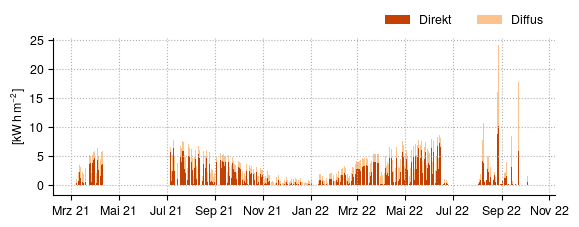

In [57]:
fig, ax = plt.subplots(**RT.size(aspect=0.4))
ax.set_ylabel(r'[\si{\kilo\watt\hour\per\square\metre}]')
df_p = AMB[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000
ax.bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'Direkt', alpha=1)
ax.bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'Diffus', alpha=1)
ax.grid(axis='both', ls = 'dotted')
#ax.tick_params(labelleft=True, labelright=True, left=True, right=True)
ax.legend(loc='lower right',ncol=99,bbox_to_anchor=(1,1),frameon=False)  
fig.tight_layout()

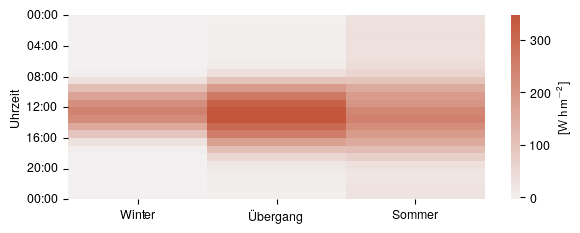

In [58]:
df = AMB[['direct','diffuse']].resample('H').mean().sum(axis=1).rename('global').to_frame().assign(Season=lambda df: RT.utils.getSeason(df.index)).pivot(columns='Season').droplevel(0,1).reindex(['Winter', 'Übergang', 'Sommer'], axis=1)
fig, ax = plt.subplots(**RT.size(aspect=0.4))
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=RT.Reds, cbar_kws={'label':r'$[\si{\watt\hour\per\square\meter}]$'})
ax.set(ylabel='Uhrzeit', xlabel=None)
fig.tight_layout()
datemapaxis(ax)

## relative Außenluftfeuchte

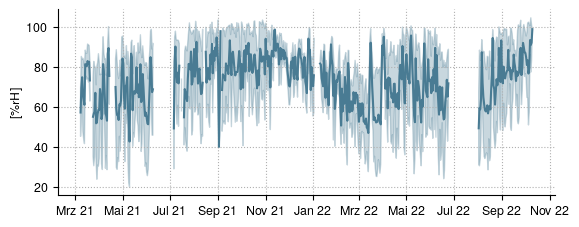

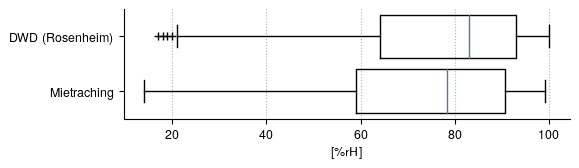

In [59]:
mean, std = AMB['Rh_amb'].resample('D').mean(), AMB['Rh_amb'].resample('D').std()
lower, upper = mean - std, mean + std
x = mean.index

fig, ax = plt.subplots(**RT.size(aspect=0.4))
ax.plot(mean, c=RT.CMAP[0])
ax.fill_between(x, lower, upper, alpha=0.3, color=RT.CMAP[0])
ax.set_ylabel(r'$[\si{\percent rH}]$')
#ax.set_title('rel. Außenluftfeuchte')
ax.grid(axis='both')
fig.tight_layout()

fig, ax = plt.subplots(**RT.size(aspect=0.3))
ax.boxplot([AMB['Rh_amb'].resample('H').mean().dropna(), refdata['rhum']], sym='+', widths = [0.8, 0.8], medianprops={'color':RT.CMAP[0]}, vert=False)
#ax.set_title('Vergleich mit der nächsen DWD-Station')
ax.set_xlabel(r'$[\si{\percent rH}]$')
ax.set_yticks([1, 2], ['Mietraching', 'DWD (Rosenheim)'])
ax.grid(axis='x')
fig.tight_layout()

# Heizung
___
[Zurück zum Anfang](#importe)

## Clustering der Messwerte der Heizkörper in ein Aktivierungssignal
---
>Hintergrund
>
>Das Heizverhalten wird im Messprojekt über einen Oberflächentemperatursensor auf den Heizkörpern überwacht. Aus diesen Temperaturdaten wird abgeleitet, wann ein Heizkörper AN oder AUS sein muss. Dazu wird die Oberflächentemperatur des Heizkörpers in relation zur Lufttemperatur gesetzt.

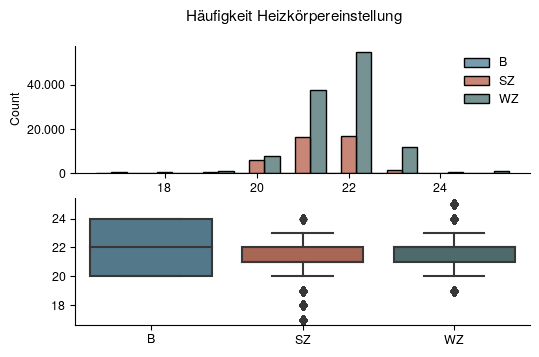

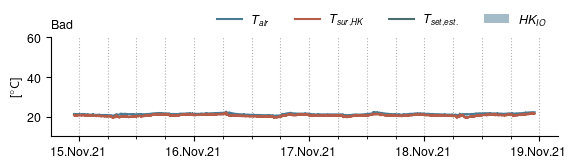

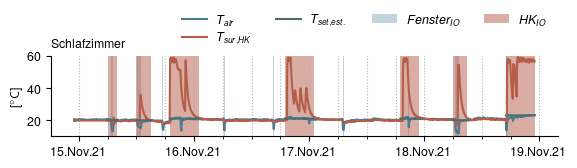

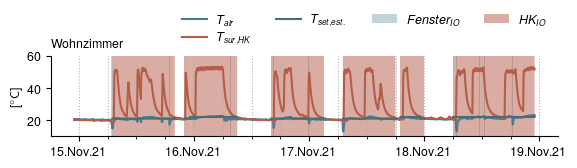

In [60]:
_hk = RT.getHKIO('MH', 'S', plot=True, start='2021-11-15', end='2021-11-18', export=False)

### Ermittle die Einstellung der Heizkörper basierend auf dem Ergebnis des Clusterings
---
>Ergebnis:
>- Einige Ausreiser im Sommer; erstmal quantile aussortieren und dann Treshhold im Preprocessing anpassen.

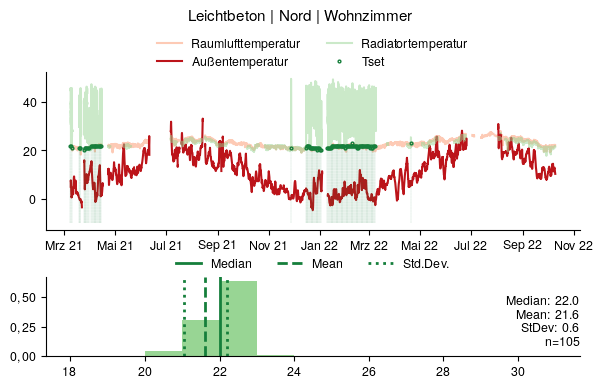

In [61]:
for bui in BUID:
    for app in APPS:
        for room in ROOMS:
            try:
                df = DB[bui][app][room]
                if not all([x in df.columns for x in ['Thk', 'Tset']]):
                    continue
            except KeyError:
                continue
            fig, axs = plt.subplots(2, 1, sharey='row', sharex='row', gridspec_kw={
                                    'height_ratios': [2, 1]})
            fig.suptitle(f'{BUID[bui]} | {APPS[app]} | {ROOMS[room]}', y=1.02)
            ax = axs[0]
            ax.plot(df['Tair'].resample('H').mean(),
                    label='Raumlufttemperatur', c=plt.cm.Reds(0.2))
            ax.plot(df['T_amb'].rolling('D').mean(),
                    c=plt.cm.Reds(0.8), label='Außentemperatur')

            ax.plot(df['Thk'], c=plt.cm.Greens(0.4),
                    alpha=0.5, label='Radiatortemperatur')
            ax.plot(df['Tset'].resample('D').median(), linestyle='None', marker='o',
                    mfc='None', markersize=2, c=plt.cm.Greens(0.8), label='Tset')

            ax.vlines(df['Tset'].resample('D').median().index, ymin=-10, ymax=df['Tset'].resample(
                'D').median(), linestyles='dashed', linewidth=.1, colors=plt.cm.Greens(0.8))

            ax.legend(ncol=2, bbox_to_anchor=(0.5, .95),loc='lower center', frameon=False)

            ax2 = axs[1]

            bins = np.arange(18, 32, 1)

            ax2.hist(df['Tset'], density=True,
                     bins=bins, color=mpl.cm.Greens(0.4))

            _mean = df['Tset'].mean()
            _median = df['Tset'].median()
            _std = df['Tset'].std()

            ax2.axvline(_median, c=mpl.cm.Greens(
                0.8), linewidth=2, label='Median')
            ax2.axvline(_mean, c=mpl.cm.Greens(0.8), linewidth=2,
                        linestyle='dashed', label='Mean')
            ax2.axvline(_mean - _std, c=mpl.cm.Greens(0.8),
                        linewidth=2, linestyle='dotted', label='Std.Dev.')
            ax2.axvline(_mean + _std, c=mpl.cm.Greens(0.8),
                        linewidth=2, linestyle='dotted')
            ax2.legend(ncol=3, bbox_to_anchor=(.5, .95), loc='lower center', frameon=False)

            ax2.text(1, 0.1, f"Median: {df['Tset'].median():.1f}\nMean: {df['Tset'].mean():.1f}\nStDev: {df['Tset'].std():.1f}\nn={df['HK_IO'].resample('D').max().sum():.0f}",
                     transform=ax2.transAxes, ha='right', va='bottom')
            fig.tight_layout(pad=0.1)
            break
        break
    break

## Ermittle Tage, an denen aktiv geheizt wird
---

In [62]:
data = RT.removeUnoccupied(RT.getData(value='HK_IO', app=['N', 'S'])).groupby(level=[0,1,2],axis=1).median().resample('H').mean().resample('D').mean()
df = data.rolling('3D', center=True).mean().round(2)
dfs = []
for (bui, app, room), group in df.groupby(level=[0,1,2], axis=1):
    mydata = group[bui, app, room].dropna()
    cluster_id = KMeans(2).fit_predict(mydata.values.reshape(-1,1))
    cluster_means = pd.Series({ii: mydata[cluster_id==ii].mean() for ii in np.unique(cluster_id)})
    status = {cluster_means.idxmax(): True, cluster_means.idxmin(): False}
    dfs.append(pd.Series(cluster_id, index=mydata.index).replace(status).rename((bui, app, room, 'HK_IO')))
RT.removeUnoccupied(pd.concat(dfs, axis=1)).reindex(RT.getData(value='HK_IO', app=['N', 'S']).index, method='ffill').where(RT.getData(value='HK_IO', app=['N', 'S']).notna())

LB                                  MH        \
                              N                 S                 N         
                              B    SZ    WZ     B    SZ    WZ     B    SZ   
                          HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO   
Datetime                                                                    
2021-02-08 11:00:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:01:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
..                          ...   ...   ...   ...   ...   ...   ...   ...   
2022-10-10 01:59:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-10-10 02:00:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                                     MW                    \
                                    S                 N                 S   
                             WZ     B    SZ    WZ     B    SZ    WZ     B   
                          HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO   
Datetime                                                                    
2021-02-08 11:00:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:01:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
..                          ...   ...   ...   ...   ...   ...   ...   ...   
2022-10-10 01:59:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-10-10 02:00:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                       
                                       
                             SZ    WZ  
                          HK_IO HK_IO  
Datetime                               
2021-02-08 11:00:00+01:00   NaN   NaN  
2021-02-08 11:01:00+01:00   NaN   NaN  
..                          ...   ...  
2022-10-10 01:59:00+02:00   NaN   NaN  
2022-10-10 02:00:00+02:00   NaN   NaN  

[876361 rows x 18 columns]

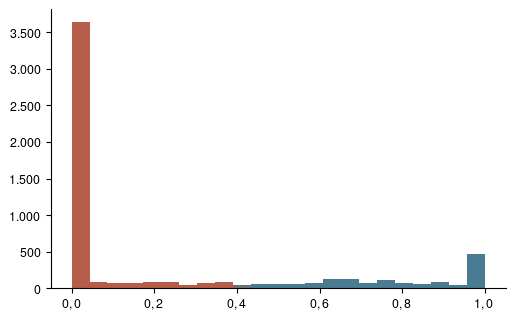

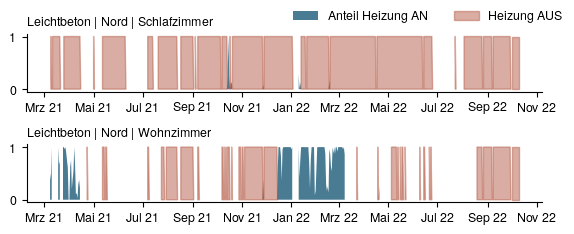

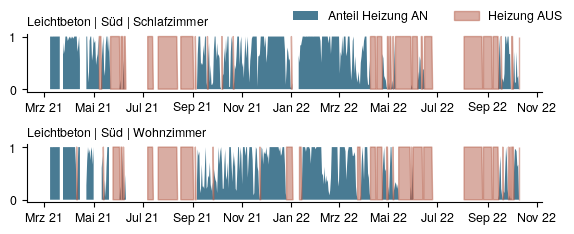

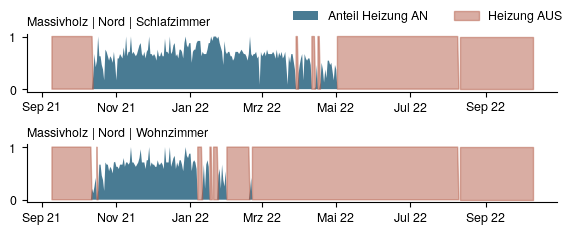

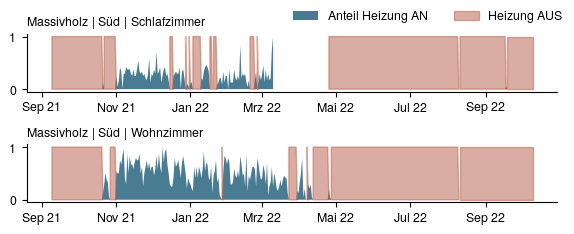

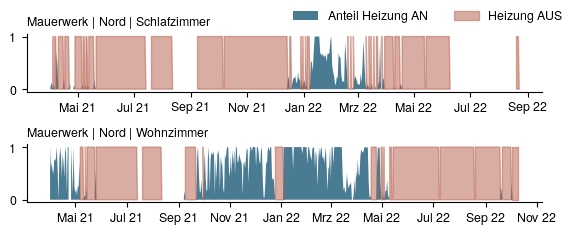

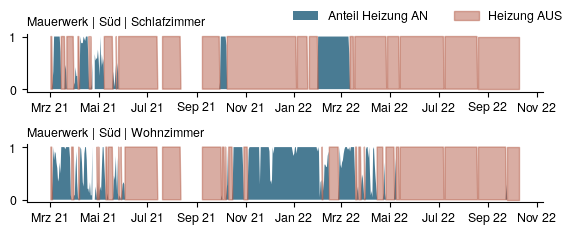

In [63]:
ref_prof = RT.getHeiztage()
data = RT.removeUnoccupied(RT.getData(value='HK_IO', app=['N', 'S'], room=['SZ', 'WZ'])).groupby(level=[0,1,2],axis=1).median().resample('H').mean().resample('D').mean()
df = data.rolling('3D', center=True).mean().round(2)
mydata = df.stack([0,1,2]).dropna()
cluster_id = KMeans(2).fit_predict(mydata.values.reshape(-1,1))
cluster_means = pd.Series({ii: mydata[cluster_id==ii].mean() for ii in np.unique(cluster_id)})
status = {cluster_means.idxmax(): True, cluster_means.idxmin(): False}
tags = {False: {'label':'Heizung AUS', 'color':RT.clrs[1]}, True: {'label':'Heizung AN', 'color':RT.clrs[0]}}
sig = pd.Series(cluster_id, index=mydata.index).map(status).rename('Heizung AN')

bins = np.linspace(mydata.min(), mydata.max(), 24)
for ii, stat in status.items():
    subset = mydata[cluster_id==ii]
    plt.hist(subset, bins=bins, **tags[stat])

HK = pd.concat([data, sig.unstack(['bui', 'app', 'room']).sort_index()], keys=['Heizung AN', 'Heizung AUS'], axis=1).reorder_levels([1,2,3,0], axis=1).sort_index(axis=1)
for (bui, app), group in HK.groupby(level=[0,1], axis=1):
    fig, axs = plt.subplots(2,1, **RT.size(aspect=0.4))
    for r, (col, roomdata) in enumerate(group.groupby(level=[0,1,2], axis=1)):
        df = roomdata[col]
        axs[r].fill_between(x=df.index, y1=df['Heizung AN'], alpha=1, label='Anteil Heizung AN')
        axs[r].fill_between(x=df.index, y1=0, y2=1, where=(df['Heizung AN']==0) & (df['Heizung AN'].notna()).where(ref_prof[col].squeeze()==0), color=RT.red, alpha=0.5, label='Heizung AUS', interpolate=True)
        #axs[r].fill_between(x=df.index, y1=0, y2=1, where=df['Heizung AN'].isna(), color='k', alpha=0.25, label='NA', transform=ax.get_xaxis_transform())
        axs[r].set_title(f'{RT.NAMES[bui]} | {RT.NAMES[app]} | {RT.NAMES[col[2]]}')
    RT.uniqueLegend(axs, fig, ncol=3)
    fig.tight_layout()

HK.filter(like='Heizung AN').droplevel(3, axis=1).to_csv('data/exporte/Heizungssignal_daily.csv')

In [64]:
df = getData(value='HK_IO', app=['N', 'S']).resample('H').max()
df.to_csv('data/exporte/Heizungssignal_hourly.csv')
df

bui                          LB                                  MH        \
app                           N                 S                 N         
room                          B    SZ    WZ     B    SZ    WZ     B    SZ   
value                     HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO   
Datetime                                                                    
2021-02-08 11:00:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 12:00:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2022-10-10 01:00:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-10-10 02:00:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

bui                                                  MW                    \
app                                 S                 N                 S   
room                         WZ     B    SZ    WZ     B    SZ    WZ     B   
value                     HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO   
Datetime                                                                    
2021-02-08 11:00:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 12:00:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2022-10-10 01:00:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-10-10 02:00:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

bui                                    
app                                    
room                         SZ    WZ  
value                     HK_IO HK_IO  
Datetime                               
2021-02-08 11:00:00+01:00   NaN   NaN  
2021-02-08 12:00:00+01:00   NaN   NaN  
...                         ...   ...  
2022-10-10 01:00:00+02:00   NaN   NaN  
2022-10-10 02:00:00+02:00   NaN   NaN  

[14607 rows x 18 columns]

## Zusammenfassung Heiztage

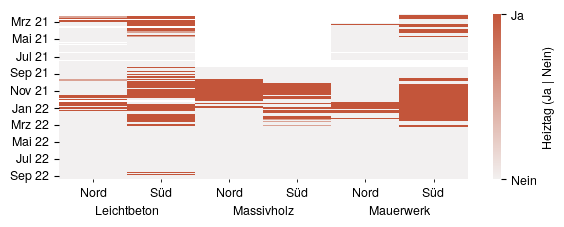

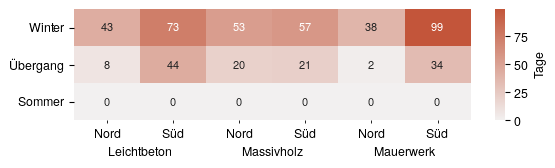

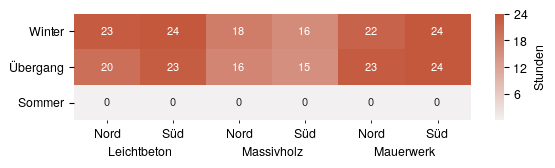

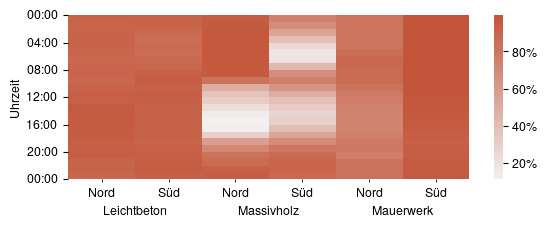

In [65]:
Heiztage = RT.getHeiztage()

fig, ax = plt.subplots(**RT.size(aspect=0.4))
df = Heiztage.resample('D').mean().groupby(level=[0,1], axis=1).median()
ax = sns.heatmap(data=df, cmap=RT.Reds, cbar_kws=dict(ticks=[0,1], label='Heiztag (Ja | Nein)'))
RT.utils.set_date_ticks(ax, df.index.min().date(), df.index.max().date(), freq='2M', date_format='%b %y')
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['Nein','Ja'])
cleanBuiAppAxis(ax, 'x')
ax.set(title=None, ylabel=None, xlabel=None)
fig.tight_layout()

df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']).mul(100).round(0)
fig, ax = plt.subplots(**RT.size(aspect=0.3))
ax = sns.heatmap(data=df, ax=ax, vmin=0, cmap=RT.Reds, annot=True, fmt='2n',annot_kws={"size":8},cbar_kws={'aspect':12, 'label':'Tage'})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

data = getData(value='HK_IO', app=['N', 'S'])
fig, ax = plt.subplots(**RT.size(aspect=0.3))
df = data.gt(0).groupby(level=[0,1], axis=1).max().resample('D').sum().where(Heiztage.resample('D').mean().groupby(level=[0,1], axis=1).median()==1).groupby(lambda x: RT.utils.getSeason(x.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(60).round(1).fillna(0)
ax = sns.heatmap(data=df, ax=ax, vmin=0, vmax=24, cmap=RT.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': 'Stunden', 'ticks':[6,12,18,24], 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

df = data.where(Heiztage==1).groupby(level=[0,1], axis=1).max()
fig, ax = plt.subplots(**RT.size(aspect=0.4))
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=RT.Reds, ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
ax.set(title=None, ylabel='Uhrzeit', xlabel=None)
datemapaxis(ax)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

## Zusammenfassung ohne berücksichtigung der Heiztage

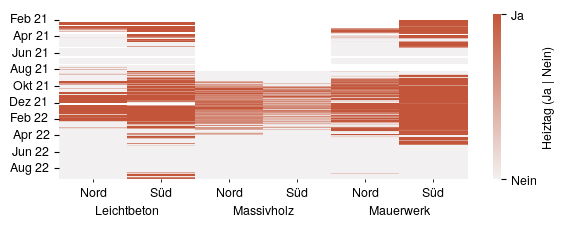

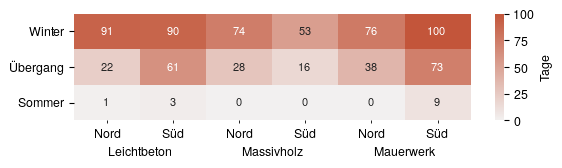

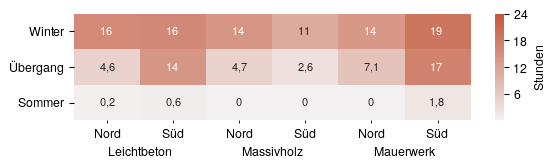

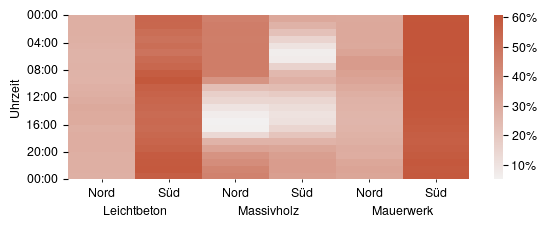

In [66]:
data = getData(value='HK_IO', app=['N', 'S'])

fig, ax = plt.subplots(**RT.size(aspect=0.4))
df = data.resample('D').mean().groupby(level=[0,1], axis=1).max()
ax = sns.heatmap(data=df, cmap=RT.Reds, cbar_kws=dict(ticks=[0,1], label='Heiztag (Ja | Nein)'))
RT.utils.set_date_ticks(ax, df.index.min().date(), df.index.max().date(), freq='2M', date_format='%b %y')
cbar = ax.collections[0].colorbar
cbar.ax.set_yticklabels(['Nein','Ja'])
cleanBuiAppAxis(ax, 'x')
ax.set(title=None, ylabel=None, xlabel=None)
fig.tight_layout()

df = df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']).mul(100).round(0)
fig, ax = plt.subplots(**RT.size(aspect=0.3))
ax = sns.heatmap(data=df, ax=ax, vmin=0, cmap=RT.Reds, annot=True, fmt='2n',annot_kws={"size":8},cbar_kws={'label': 'Tage', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

fig, ax = plt.subplots(**RT.size(aspect=0.3))
df = data.gt(0).groupby(level=[0,1], axis=1).max().resample('D').sum().groupby(lambda x: RT.utils.getSeason(x.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(60).round(1).fillna(0)
ax = sns.heatmap(data=df, ax=ax, vmin=0, vmax=24, cmap=RT.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': 'Stunden', 'ticks':[6,12,18,24], 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

fig, ax = plt.subplots(**RT.size(aspect=0.4))
df = data.groupby(level=[0,1], axis=1).max()
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=RT.Reds, ax=ax)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
ax.set(title=None, ylabel='Uhrzeit', xlabel=None)
datemapaxis(ax)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

hkio = df.copy()

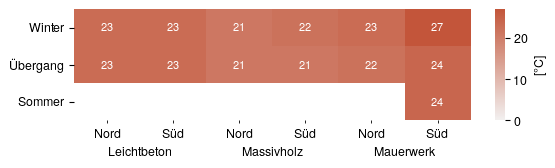

In [67]:
data = getData(value='Tset', app=['N', 'S'])
Heiztage = RT.getHeiztage()
df = data.droplevel(3, axis=1).where(Heiztage.droplevel(3, axis=1)).groupby(level=[0,1], axis=1).max().resample('D').median()
df = df.groupby(RT.utils.getSeason(df.index)).median().reindex(['Winter', 'Übergang', 'Sommer']).round(0)
fig, ax = plt.subplots(**RT.size(aspect=0.3))
ax = sns.heatmap(data=df, ax=ax, vmin=0, cmap=RT.Reds, annot=True, fmt='2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\celsius}]', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

## Ermittlung der Heizgrenztemperatur

In [68]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold

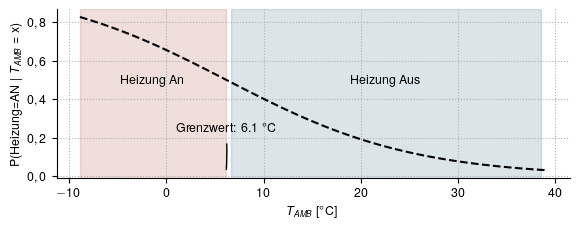

In [69]:
df = getData(value='HK_IO', app=['N', 'S']).resample('H').median().stack([0,1,2]).reset_index(['bui', 'app', 'room'], drop=True).merge(AMB['T_amb'].round(1), left_index=True, right_index=True, how='outer').dropna()

y = df['HK_IO'].astype('int')
X = df['T_amb'].astype('float').values.reshape(-1,1)

log_reg = LogisticRegressionCV(solver='liblinear', class_weight='balanced', scoring='roc_auc').fit(X, y)
X_pred = np.arange(X.min(), X.max(), 0.5)
y_pred = log_reg.predict(X_pred.reshape(-1,1))
x = np.linspace(X.min(), X.max(), 100)
y = log_reg.predict_proba(x.reshape(-1,1))[:,1]

fig, ax = plt.subplots(**RT.size(aspect=0.4))
ax.plot(x,y, ls='dashed', color='k')
HK = pd.Series(y_pred, index=X_pred, name='HK').reset_index().groupby('HK').agg(['min', 'max']).droplevel(0, axis=1)
stat = {1: 'An', 0: 'Aus'}
for status, (_min, _max) in HK.iterrows():
    ax.axvspan(_min, _max, color=RT.clrs[status], alpha=0.2)
    ax.text((_min+_max)/2, 0.5, f'Heizung {stat[status]}', va='center', ha='center')
ax.annotate(f"Grenzwert: {_max} \\si{{\\celsius}}", (_max, 0), xytext=(_max, 0.25), ha='center', va='center', arrowprops=dict(arrowstyle='-', connectionstyle="arc3,rad=-0.05",color="k", shrinkA=5, shrinkB=5))
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(steps=[1,5,10]))
ax.set_xlabel(r'$T_{AMB}$ [\si{\celsius}]')
ax.grid(axis='both')
ax.set_ylabel(r'P(Heizung=AN | $T_{AMB}$ = x)')
fig.tight_layout()

## Wärmeenergieverbrauch

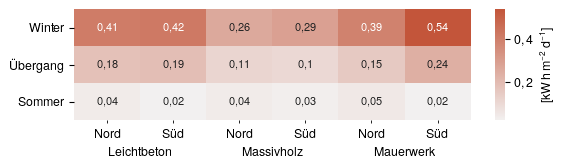

In [70]:
df = getData(value='Wärmemenge', app=['N', 'S']).droplevel(['room', 'value'], axis=1).dropna(how='all').diff().resample('D').sum().groupby(lambda s: RT.utils.getSeason(s.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(RT.AREA, axis=1, level=1).dropna(axis=1)

fig, ax = plt.subplots(1,1, **RT.size(aspect=0.3))
ax = sns.heatmap(data=df.round(2), ax = ax, cmap=RT.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kilo\watt\hour\per\square\metre\per\day}]','aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

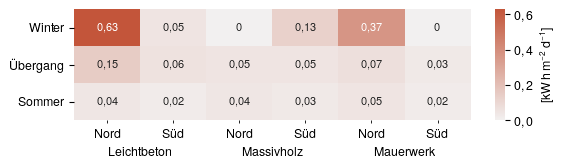

In [71]:
Heiztage = RT.getHeiztage()
df = getData(value='Wärmemenge', app=['N', 'S']).droplevel(['room', 'value'], axis=1).dropna(how='all').diff().resample('D').sum().where(Heiztage.astype(float).groupby(level=[0,1], axis=1).max().resample('D').median().eq(0)).groupby(lambda s: RT.utils.getSeason(s.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(RT.AREA, axis=1, level=1).fillna(0)

fig, ax = plt.subplots(1,1, **RT.size(aspect=0.3))
ax = sns.heatmap(data=df.round(2), ax = ax, cmap=RT.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kilo\watt\hour\per\square\metre\per\day}]','aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

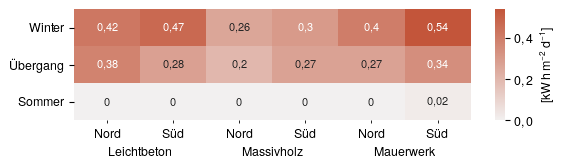

In [72]:
df = getData(value='Wärmemenge', app=['N', 'S']).droplevel(['room', 'value'], axis=1).dropna(how='all').diff().resample('D').sum().where(Heiztage.astype(float).groupby(level=[0,1], axis=1).max().resample('D').median().gt(0)).groupby(lambda s: RT.utils.getSeason(s.month)).mean().reindex(['Winter', 'Übergang', 'Sommer']).div(RT.AREA, axis=1, level=1).fillna(0)

fig, ax = plt.subplots(1,1, **RT.size(aspect=0.3))
ax = sns.heatmap(data=df.round(2), ax = ax, cmap=RT.Reds, annot=True, fmt='.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kilo\watt\hour\per\square\metre\per\day}]','aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

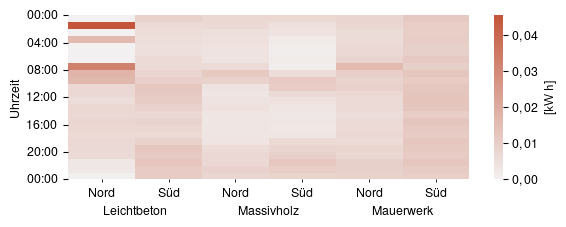

In [73]:
fig, ax = plt.subplots(1,1, **RT.size(aspect=0.4))
df = getData(value='Wärmemenge', app=['N', 'S']).droplevel(['room', 'value'], axis=1).dropna(how='all').diff()
ax = sns.heatmap(data=df.groupby(df.index.hour).mean(), cmap=RT.Reds, ax = ax, cbar_kws={'label': r'$[\si{\kilo\watt\hour}]$'} )
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

# **Thermischer Komfort**
___
[Zurück zum Anfang](#importe)

## adaptives Komfortmodell

In [74]:
KH = RT.getAdaptiveComfort(occupied=True)
KH.head()

bui                         LB                                                \
app                          N                   O                    S        
norm                        EN        NA        EN         NA        EN        
value                     UTGS ÜTGS UTGS ÜTGS UTGS ÜTGS  UTGS ÜTGS UTGS ÜTGS   
Datetime                                                                       
2021-03-08 11:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   
2021-03-08 12:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN  0.05  NaN  NaN  NaN   
2021-03-08 13:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   
2021-03-08 14:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN  0.30  NaN  NaN  NaN   
2021-03-08 15:00:00+01:00  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  NaN  NaN   

bui                        ...   MW                                          \
app                        ...    N         O                   S             
norm                       ...   NA        EN        NA        EN        NA   
value                      ... UTGS ÜTGS UTGS ÜTGS UTGS ÜTGS UTGS ÜTGS UTGS   
Datetime                   ...                                                
2021-03-08 11:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2021-03-08 12:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2021-03-08 13:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2021-03-08 14:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
2021-03-08 15:00:00+01:00  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

bui                             
app                             
norm                            
value                     ÜTGS  
Datetime                        
2021-03-08 11:00:00+01:00  NaN  
2021-03-08 12:00:00+01:00  NaN  
2021-03-08 13:00:00+01:00  NaN  
2021-03-08 14:00:00+01:00  NaN  
2021-03-08 15:00:00+01:00  NaN  

[5 rows x 36 columns]

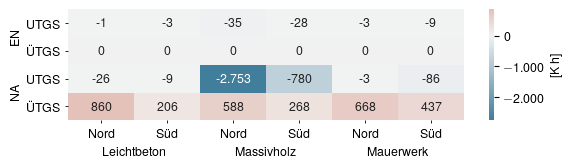

In [75]:
kh = KH.loc[:, IDX[:,['N','S'],:,:]].sort_index(axis=1).sum().round().unstack([2,3]).T
kh.loc[IDX[:,'UTGS'],:] *= -1
fig = plt.figure(**RT.size(aspect=0.3))
ax = sns.heatmap(data=kh, cmap=RT.HEATMAP, center=0, annot=True, fmt='4n', cbar_kws=dict(label=r'[\si{\kelvin\hour}]'))
cleanBuiAppAxis(ax)
cleanBuiAppAxis(ax, 'y')
ax.tick_params(axis='y', which='major', length=30)
fig.tight_layout()

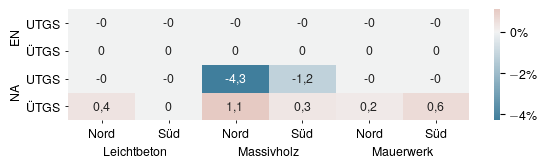

In [76]:
df = (RT.getOccupied(KH).sort_index(axis=1) > 2).sum().unstack([2,3]).div(RT.getHoursOccupied(app=['N','S']), axis=0).mul(100).dropna().T.round(1)
df.loc[IDX[:,'UTGS'],:] *= -1
fig = plt.figure(**RT.size(aspect=0.3))
ax = sns.heatmap(data=df, cmap=RT.HEATMAP,center=0, annot=True, fmt='1n')
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(100, 0, symbol='%'))
cleanBuiAppAxis(ax)
cleanBuiAppAxis(ax, 'y')
ax.tick_params(axis='y', which='major', length=30)
fig.tight_layout()

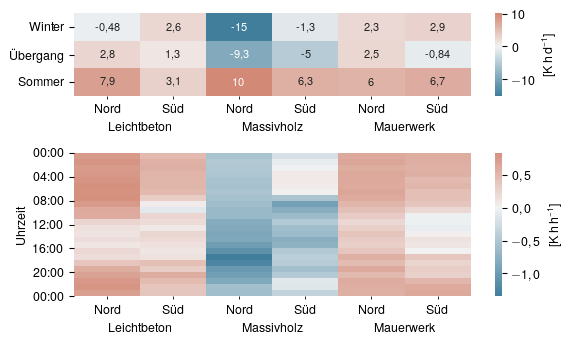

In [77]:
df = KH.loc[:,IDX[:,['N','S'],'NA','ÜTGS']].droplevel([2,3], axis=1).resample('D').sum(min_count=1).fillna(KH.loc[:,IDX[:,['N','S'],'NA','UTGS']].droplevel([2,3], axis=1).resample('D').sum(min_count=1).mul(-1))

fig, axs = plt.subplots(2,1, **RT.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
ax = sns.heatmap(ax=axs[0], data=df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']), center=0, cmap=RT.HEATMAP, annot=True, fmt='2.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kelvin\hour\per\day}]', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = KH.loc[:,IDX[:,['N','S'],'NA','ÜTGS']].droplevel([2,3], axis=1).fillna(KH.loc[:,IDX[:,['N','S'],'NA','UTGS']].droplevel([2,3], axis=1).mul(-1))
ax = sns.heatmap(ax=axs[1], data=df.groupby(df.index.hour).mean().fillna(0), cmap=RT.HEATMAP, center=0, cbar_kws={'label': r'[\si{\kelvin\hour\per\hour}]'})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

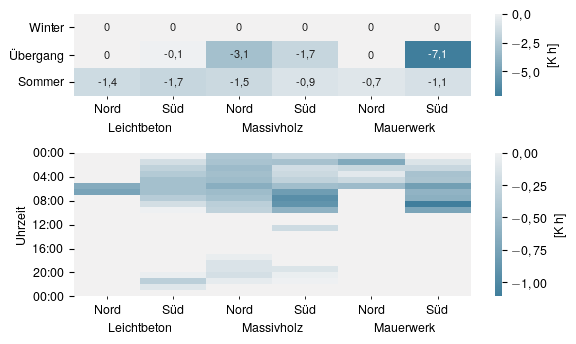

In [78]:
fig, axs = plt.subplots(2,1, **RT.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = KH.loc[:,IDX[:,['N','S'],'EN','ÜTGS']].droplevel([2,3], axis=1).resample('D').sum(min_count=1).fillna(KH.loc[:,IDX[:,['N','S'],'EN','UTGS']].droplevel([2,3], axis=1).resample('D').sum(min_count=1).mul(-1))
ax = sns.heatmap(ax=axs[0], data=df.groupby(RT.utils.getSeason(df.index)).mean().round(1).fillna(0).reindex(['Winter', 'Übergang', 'Sommer']), center=0, cmap=RT.HEATMAP, annot=True, fmt='2.2n',annot_kws={"size":8},cbar_kws={'label': r'[\si{\kelvin\hour}]', 'aspect': 12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = KH.loc[:,IDX[:,['N','S'],'EN','ÜTGS']].droplevel([2,3], axis=1).fillna(KH.loc[:,IDX[:,['N','S'],'EN','UTGS']].droplevel([2,3], axis=1).mul(-1))
ax = sns.heatmap(ax=axs[1], data=df.groupby(df.index.hour).mean().fillna(0), cmap=RT.HEATMAP, center=0,cbar_kws={'label': r'[\si{\kelvin\hour}]'})
ax.set(title=None, ylabel='Uhrzeit', xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
fig.tight_layout()

## PMV/PPD

In [79]:
PMV, pmv_params = RT.calculatePMVPPD()
PMV.head()

Berechne PMV und PPD für Schlafzimmer und Wohnzimmer


bui                         LB                                           ...  \
app                          N                                           ...   
room                        SZ                                           ...   
value                     Tair Top  Rh met clo vair v_rel clo_d pmv ppd  ...   
Datetime                                                                 ...   
2021-02-09 11:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   
2021-02-09 12:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   
2021-02-09 13:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   
2021-02-09 14:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   
2021-02-09 15:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  ...   

bui                         MW                                           
app                          S                                           
room                        WZ                                           
value                     Tair Top  Rh met clo vair v_rel clo_d pmv ppd  
Datetime                                                                 
2021-02-09 11:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  
2021-02-09 12:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  
2021-02-09 13:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  
2021-02-09 14:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  
2021-02-09 15:00:00+01:00  NaN NaN NaN NaN NaN  NaN   NaN   NaN NaN NaN  

[5 rows x 150 columns]

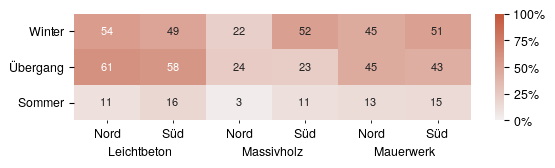

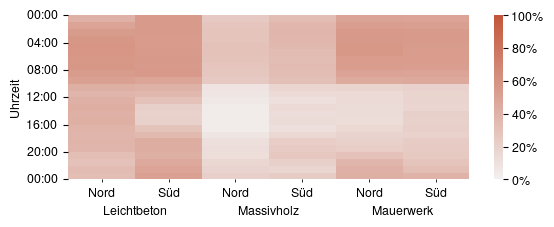

In [80]:
df = RT.getOccupied(PMV).loc[:, IDX[:,['N', 'S'],:,'pmv']].groupby(level=[0,1], axis=1).max().abs().lt(0.5)

fig, ax = plt.subplots(**RT.size(aspect=0.3))
ax = sns.heatmap(data=df.groupby(RT.utils.getSeason(df.index)).mean().fillna(0).reindex(['Winter', 'Übergang', 'Sommer']).mul(100), vmin=0, vmax=100, cmap=RT.Reds, annot=True, fmt='.2n',annot_kws={"size":8}, cbar_kws={'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(100, 0, symbol='%'))
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

fig, ax = plt.subplots(**RT.size(aspect=0.4))
ax = sns.heatmap(data=df.groupby(df.index.hour).mean().fillna(0), cmap=RT.Reds, vmin=0, vmax=1)
ax.set(title=None, ylabel='Uhrzeit', xlabel=None)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax, 'y')
fig.tight_layout()

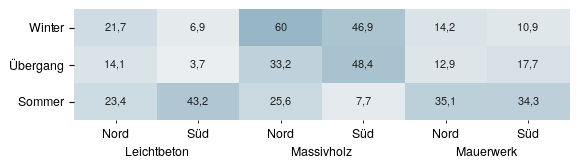

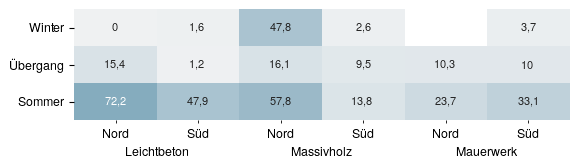

In [81]:
df = RT.getOccupied(PMV).loc[:, IDX[:,['N', 'S'],:,:]]
pmv = []
for (bui, app, room), group in df.groupby(level=[0,1,2], axis=1):
    group = group.stack([0,1,2]).reset_index()
    group = group.assign(comf = group['pmv'].abs().lt(0.5))
    pmv.append(group.groupby((group.comf != group.comf.shift()).cumsum()).agg({'bui':'first', 'app':'first', 'room': 'first', 'Datetime':['first', 'last', RT.utils.aggMINMAX], 'pmv': ['mean'], 'comf':['mean']}).set_axis(['bui', 'app', 'room', 'start','end', 'duration', 'pmv_mean', 'comfortable'], axis=1).where(lambda df: df.comfortable==0).dropna(how='all'))
pmv = pd.concat(pmv).reset_index(drop=True).assign(Season = lambda x: RT.utils.getSeason(x.start))
df = pmv.groupby(['bui', 'app', 'room', 'Season'])['duration'].agg(['mean']).apply(lambda x: x.dt.total_seconds()/60/60).unstack(['bui', 'app']).droplevel(0, axis=1)

fig, ax = plt.subplots(**RT.size(aspect=0.3))
ax = sns.heatmap(data=df.loc['SZ'].round(1).reindex(['Winter', 'Übergang', 'Sommer']), cmap=RT.Blues, annot=True, fmt='2n', vmin=0, vmax=120, cbar=None, annot_kws={"size":8}, cbar_kws=dict(label='$\si{\hour}$'))
ax.set(title=None, xlabel=None, ylabel=None)
cleanBuiAppAxis(ax)
fig.tight_layout()

fig, ax = plt.subplots(**RT.size(aspect=0.3))
ax = sns.heatmap(data=df.loc['WZ'].round(1).reindex(['Winter', 'Übergang', 'Sommer']), cmap=RT.Blues, annot=True, fmt='2n', vmin=0, vmax=120, cbar=None, annot_kws={"size":8}, cbar_kws=dict(label='$\si{\hour}$'))
ax.set(title=None, xlabel=None, ylabel=None)
cleanBuiAppAxis(ax)
fig.tight_layout()

# **Fensteröffnung**
___
[Zurück zum Anfang](#importe)

Lade gespeicherte LüftungsDB...
Extrahiere Lüftungen...
Dauer 0 days 12:03:00, Temperaturpotential nan                                                                                                    
Abkühlzeit: 0 days 07:37:00
Abkühlzeit: 0 days 07:37:00
delta T: -3.1 K
Die Raumtemperatur steigt bereits bei geöffnetem Fenster.
Aufwärmzeit (Fenster offen): 0 days 04:26:00
Aufwärmzeit (Fenster geschlossen): 0 days 07:47:00
delta T: 2.8 K
Keine Wetterdaten vorhanden....
Datensatz wird trotzdem verwendet!


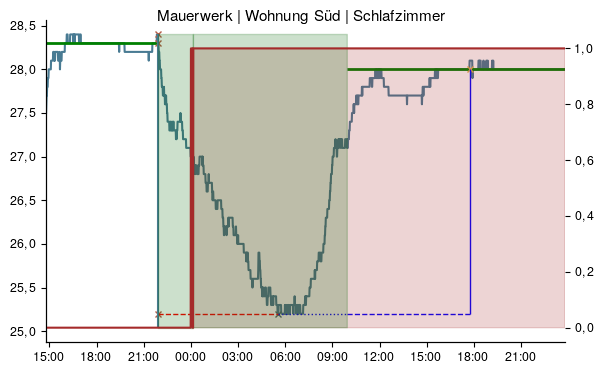

In [82]:
room = 'SZ'
RT.plotLüftung(bui, app, room)

## Importiere Lüftungsdatensatz

In [83]:
L_stats = RT.getLüftungsStats()
L_stats = L_stats[L_stats.duration < pd.Timedelta(24, 'hours')]
L_stats = L_stats.assign(Season= lambda x: RT.utils.getSeason(x.idx_opening))
L_stats = L_stats.loc[IDX[:,['N', 'S'],:],:]

## Zusammenfassung

### absulte Häufigkeit der Fensteröffnung

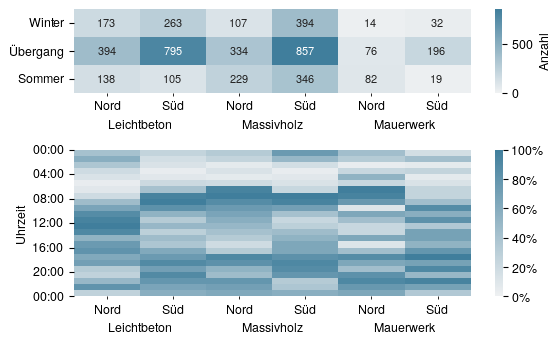

In [84]:
fig, axs = plt.subplots(2,1, **RT.size(aspect=0.6), gridspec_kw=dict(height_ratios=[1,1.75]))
df = L_stats.reset_index().groupby(['bui', 'app', 'Season']).size().unstack(['bui', 'app']).reindex(['Winter', 'Übergang', 'Sommer'])
ax = sns.heatmap(ax=axs[0], data=df, vmin=0, cmap=RT.Blues, annot=True, fmt='3n',annot_kws={"size":8}, cbar_kws={'label':'Anzahl', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
df = L_stats['idx_opening'].dt.hour.reset_index().groupby(['bui', 'app', 'idx_opening']).size().unstack(['bui', 'app'])
ax = sns.heatmap(ax=axs[1], data=df.rank(axis=0, pct=True), cmap=RT.Blues, vmin=0)
ax.set(title=None, ylabel='Tageszeit', xlabel=None)
cleanBuiAppAxis(ax, 'x')
datemapaxis(ax)
cbar = ax.collections[0].colorbar
cbar.ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, 0, symbol='%'))
fig.tight_layout()

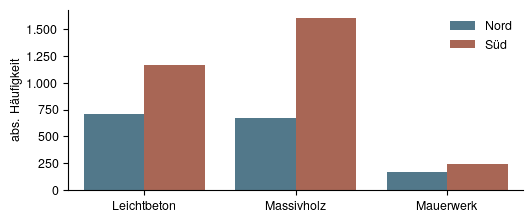

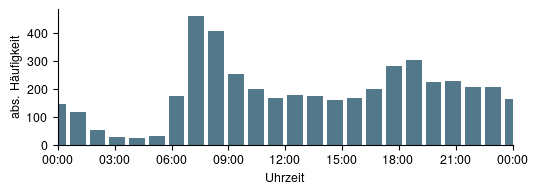

In [85]:
plt.figure(**RT.size(aspect=0.4))
ax = sns.countplot(data=L_stats.rename(index=RT.NAMES, columns=RT.NAMES).reset_index(), x='bui', hue='app')
ax.set(title=None, ylabel='abs. Häufigkeit', xlabel=None)
ax.legend(title=None)
fig.tight_layout()

plt.figure(**RT.size(aspect=0.3))
ax = sns.countplot(x=L_stats['idx_opening'].dt.hour, color = RT.clrs[0])
ax.set(title=None, ylabel='abs. Häufigkeit', xlabel='Uhrzeit')
RT.datemapaxis(ax, axis='x', steps=8)
fig.tight_layout()

## Anteil geöffneter Fenster (Gesamt)

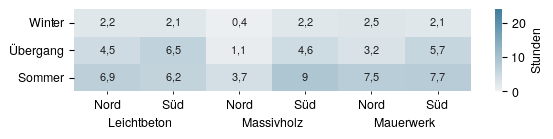

In [86]:
data = DB.loc[:,IDX[:,['N', 'S'],:,'Fenster']].gt(0).groupby(level=[0,1], axis=1).max()

fig, ax = plt.subplots(**RT.size(aspect=0.25))
df = data.resample('D').sum()/60
ax = sns.heatmap(data=df.groupby(RT.utils.getSeason(df.index)).mean().reindex(['Winter', 'Übergang', 'Sommer']).round(1), vmin=0, vmax=24, cmap=RT.Blues, annot=True, fmt='2n',annot_kws={"size":8},cbar_kws={'label': 'Stunden', 'aspect':12})
ax.set(title=None, ylabel=None, xlabel=None)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()

## Mittlere Dauer einer Lüftung
Bruacht [import](#importiere-lüftungsdatensatz) von `L_stats`

duration: 13% Outliner (IQR=-105.5, 194.5) entfernt


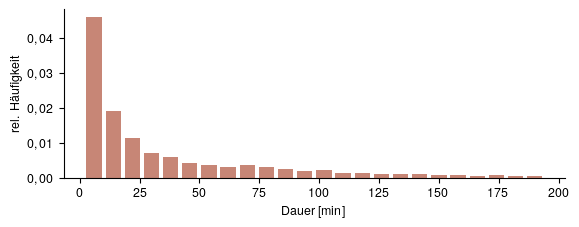

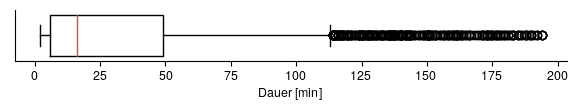

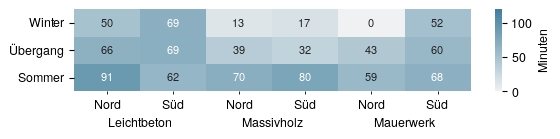

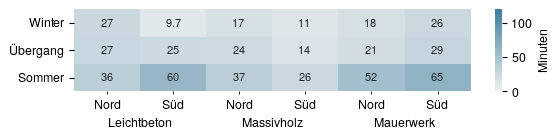

In [87]:
DurationOfOpening = L_stats.reset_index()[['bui', 'app','room', 'idx_opening', 'duration']]
DurationOfOpening['HoD'] = DurationOfOpening.idx_opening.dt.hour
DurationOfOpening['duration'] = DurationOfOpening.duration.dt.total_seconds().div(60)
DurationOfOpening = RT.utils.removeOutliner(DurationOfOpening.where(DurationOfOpening.duration > 0), col='duration')
DurationOfOpening['bins'] = pd.qcut(DurationOfOpening.duration, 3, labels=['short', 'medium', 'long'])

fig, ax = plt.subplots(**RT.size(aspect=0.4))
sns.histplot(data=DurationOfOpening, x='duration', stat='density', color = RT.clrs[1], shrink=.8, ec='None', bins=24)
ax.set(title=None, ylabel='rel. Häufigkeit', xlabel=r'Dauer $[\si{\min}]$')
fig.tight_layout()

fig, ax = plt.subplots(**RT.size(aspect=0.2))
ax.boxplot(DurationOfOpening['duration'].dropna(), vert=False, widths=.8)
ax.set(yticklabels=[], xlabel=r'Dauer $[\si{\min}]$')
ax.yaxis.set_visible(False)
fig.tight_layout()

df = DurationOfOpening[DurationOfOpening.app != 'O'].assign(Season = lambda x: RT.utils.getSeason(x.idx_opening)).groupby(['bui', 'app', 'room', 'Season']).duration.mean().unstack([0,1])
for r, (room, _df) in enumerate(df.groupby('room')):
    fig, ax = plt.subplots(**RT.size(aspect=0.25))
    ax = sns.heatmap(data=_df.droplevel(0).fillna(0).reindex(['Winter', 'Übergang', 'Sommer']), cmap=RT.Blues, annot=True, vmin=0, vmax=120, annot_kws={"size":8}, cbar_kws=dict(aspect=12, label='Minuten'))
    ax.set(title=None, xlabel=None, ylabel=None)
    cleanBuiAppAxis(ax)
    fig.tight_layout()


Wenn $T_{amb, 24h} > 6°C$:
$$\mathrm{Fenster}[open, closed] = \begin{cases}
    \text{open if }& T_{air} >22°C, \\ 
    \text{closed if} & T_{air} < 18 °C, \\
    \text{closed if} & T_{amb} > (T_{air} + 3K), \\
    \text{closed otherwise.}
\end{cases}
$$


Wenn $T_{amb, 24h} > 6°C$:
$$\mathrm{Fenster}[open, closed] = \begin{cases}
    \text{open if }& T_{air} >25°C, \\ 
    \text{closed if} & T_{air} < 22 °C, \\
    \text{closed if} & T_{amb} > (T_{air} + 3K), \\
    \text{closed otherwise.}
\end{cases}
$$

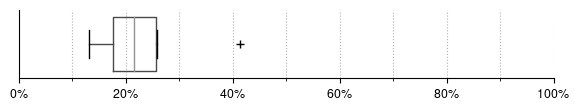

In [88]:
T_vent = DB.loc[:,IDX[:,:,['WZ', 'SZ'],['Tair', 'T_amb', 'Fenster']]].resample('H').mean().stack([0,1,2]).reset_index([1,2,3]).where(AMB.T_amb.resample('D').mean().resample('H').ffill() > 6).where(lambda df: (df.Tair > 22) & (df.T_amb < df.Tair + 3)).dropna(how='all')

fig, ax = plt.subplots(**RT.size(aspect=0.2))
df = T_vent.set_index(['bui', 'app', 'room'], append=True).Fenster.gt(0).groupby(['bui', 'app']).value_counts(normalize=True).rename('n_open').unstack('Fenster')[True].to_frame()
df.boxplot(vert=False, widths=.8, sym='+')
ax.set_xlim(0,1)
ax.yaxis.set_visible(False)
ax.yaxis.label.set_visible(False)
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.1))
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, is_latex=False, decimals=0))
ax.grid(which='both', axis='x', ls='dotted')
fig.tight_layout()

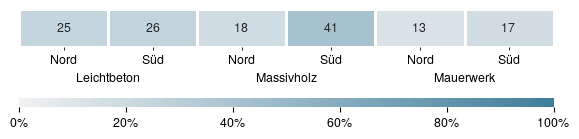

In [89]:
grid_kws = {"height_ratios": (8, 2)}
fig, (ax, cbar_ax) = plt.subplots(2,1, **RT.size(aspect=.25), gridspec_kw=grid_kws)
ax = sns.heatmap(data=df[True].to_frame().T.mul(100), cmap=RT.Blues, ax=ax, annot=True, fmt='.2n', vmin=0, vmax=100, cbar_ax=cbar_ax, linewidths=1, cbar_kws={"orientation": "horizontal"})
ax.set(title=None, ylabel=None, xlabel=None, yticklabels=[])
ax.yaxis.set_visible(False)
cbar = ax.collections[0].colorbar
cbar.ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(100, 0, symbol='%'))
ax.tick_params(axis='y', rotation=0)
cleanBuiAppAxis(ax, 'x')
fig.tight_layout()